# Analysis of Dynamic PIE Simulations

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import fretbursts as fb
import fretbursts
import burstH2MM as bhm
%config InlineBackend.figure_format='retina'

# BVA functions from https://bursth2mm.readthedocs.io/en/latest/burstH2MM_HP3_TE300_PIE_paper.html#Environment-setup
#sns = fretbursts.init_notebook()
def bin_bva(E, std, R, B_thr):
    E, std = np.concatenate(E), np.concatenate(std)
    bn = np.linspace(0,1, R+1)
    std_avg, E_avg = np.empty(R), np.empty(R)
    for i, (bb, be) in enumerate(zip(bn[:-1], bn[1:])):
        mask = (bb <= E) * (E < be)
        if mask.sum() > B_thr:
            std_avg[i], E_avg[i] = np.mean(std[mask]), np.mean(E[mask])
        else:
            std_avg[i], E_avg[i] = -1, -1
    return E_avg, std_avg

def BVA(data, chunck_size):
    """
    Perform BVA analysis on a given data set.
    Calculates the std dev E in each burst.
    ----------
    d: FRETBursts data object
        A FRETBursts data object, must have burst selection already performed.
    chunk_size: int
        Size of the sub-bursts to assess E
    Returns
    -------
    E_eff: list[np.ndarray[float]]
        Raw FRET efficiency of each burst
    std_E: list[np.ndarray[float]]
        Standard deviation of FRET values of each burst

    """
    E_eff, std_E = list(), list()
    for ich, mburst in enumerate(data.mburst): # iterate over channels
        # create lists to store values for burst in channel
        stdE, E = list(), list()
        # get masking arrays before iterating over bursts
        Aem = data.get_ph_mask(ich=ich, ph_sel=fb.Ph_sel(Dex='Aem')) # get acceptor instances to calculate E
        Dex = data.get_ph_mask(ich=ich, ph_sel=fb.Ph_sel(Dex='DAem')) # get Dex mask to remove Aex photons
        for istart, istop in zip(mburst.istart, mburst.istop): # iterate over each burst
            phots = Aem[istart:istop+1][Dex[istart:istop+1]] # Dex photons in burst True if Aem and False if Dem
            # list of number of Aem in each chunch, easier as list comprehansion
            Esub = [phots[nb:ne].sum() for nb, ne in zip(range(0,phots.size, chunck_size),
                                                         range(chunck_size,phots.size+1, chunck_size))]
            # Cacluate burst-wise value and append to list of bursts in channel
            stdE.append(np.std(Esub)/chunck_size) # calculate and append standard deviation
            E.append(sum(Esub)/(len(Esub)*chunck_size)) # calculate E

        # convert single-channel list to array and add to channel list
        E_eff.append(np.array(E))
        std_E.append(np.array(stdE))
    return E_eff, std_E



        The current file lacks the alternation period definition.
        You will need to manually add this info using:

          d.add(D_ON=D_ON, A_ON=A_ON)

        where `d` is a Data object and D_ON/A_ON is a tuple with start/stop
        values defining the D/A excitation excitation period. Values are in
        raw timestamps units.
        


# Total photons (after ALEX selection):     4,413,340
#  D  photons in D+A excitation periods:    1,846,780
#  A  photons in D+A excitation periods:    2,566,560
# D+A photons in  D  excitation period:     2,225,291
# D+A photons in  A  excitation period:     2,188,049

 - Calculating BG rates ... get bg th arrays
Channel 0
[DONE]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 5948 bursts (33.9%, 13 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A and FRET]
<class 'matplotlib.figure.Figure'>
<class 'matplotlib.figure.Figure'>


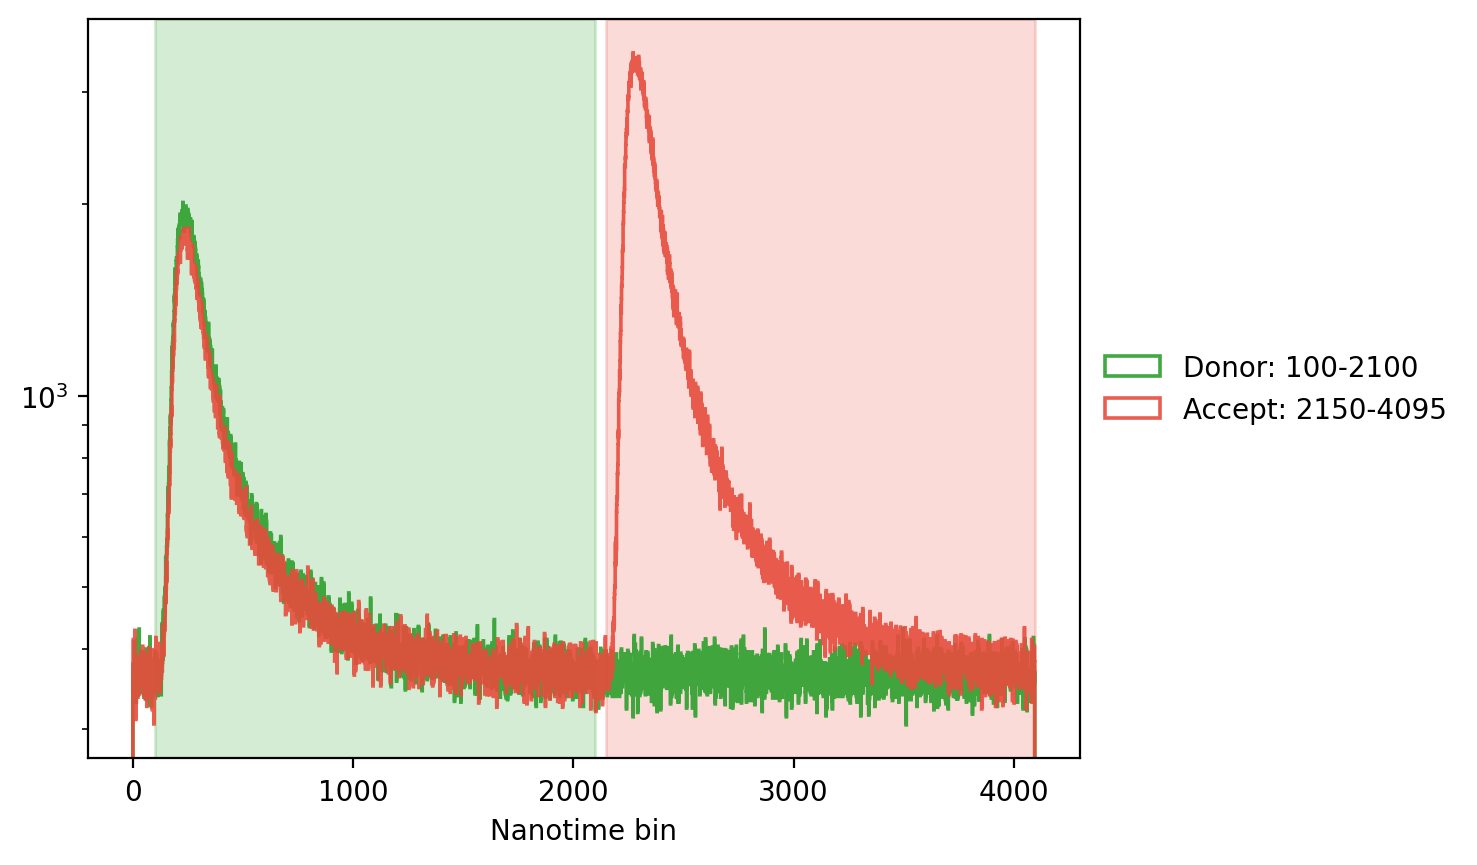

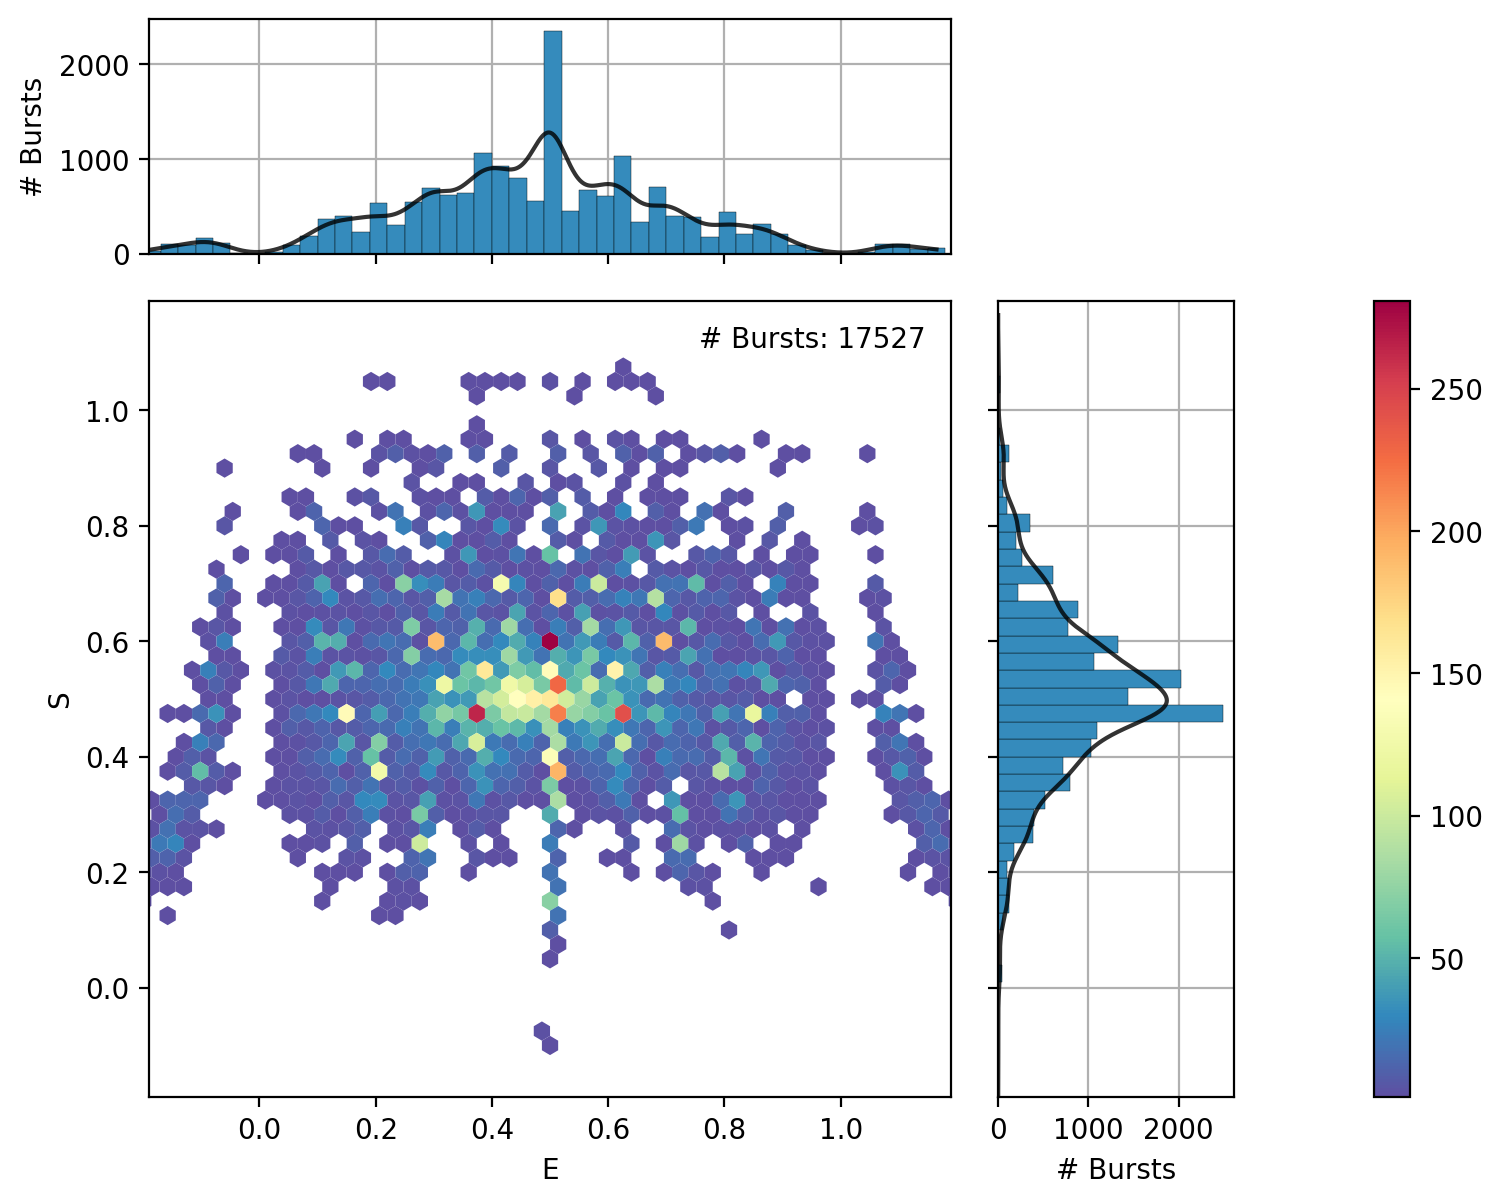

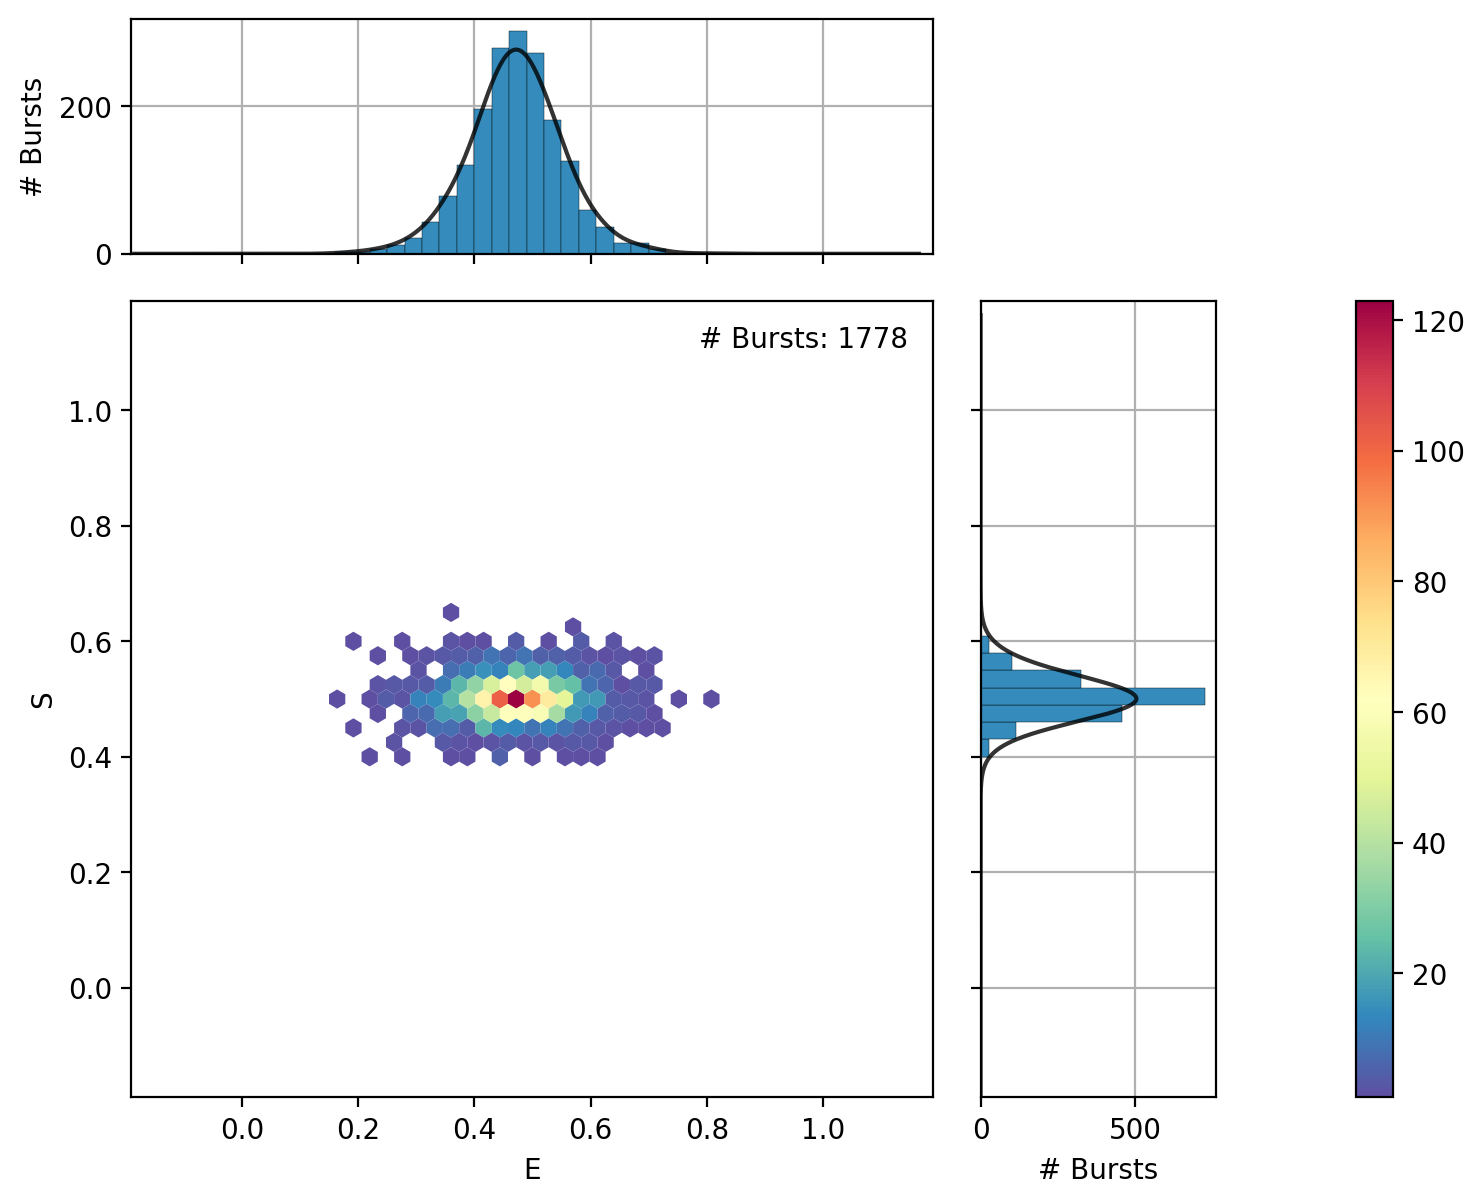

In [193]:
d = fb.loader.photon_hdf5(
        "Speed_Titration/smFRET_aa3ff9_E15E80_2states_taus_0.05ms0.05ms.h5"
)
d.add(D_ON=(100, 2100), A_ON=(2150, 4095))
#d.add(D_ON=(4, 7), A_ON=(0, 3))
fb.plot_alternation_hist(d)
fb.loader.alex_apply_period(d)

d.calc_bg(fun=fb.bg.exp_fit, time_s = 60, F_bg=1.7)
d.burst_search(F=7, m = 10)
d.fuse_bursts(ms = 0)

ds = d.select_bursts(fb.select_bursts.size, add_naa = False, th1=60)
ds = ds.select_bursts(fb.select_bursts.naa, th1=40)

fb.alex_jointplot(d);
fb.alex_jointplot(ds);

Average burst duration in ms: 2.168209505061867


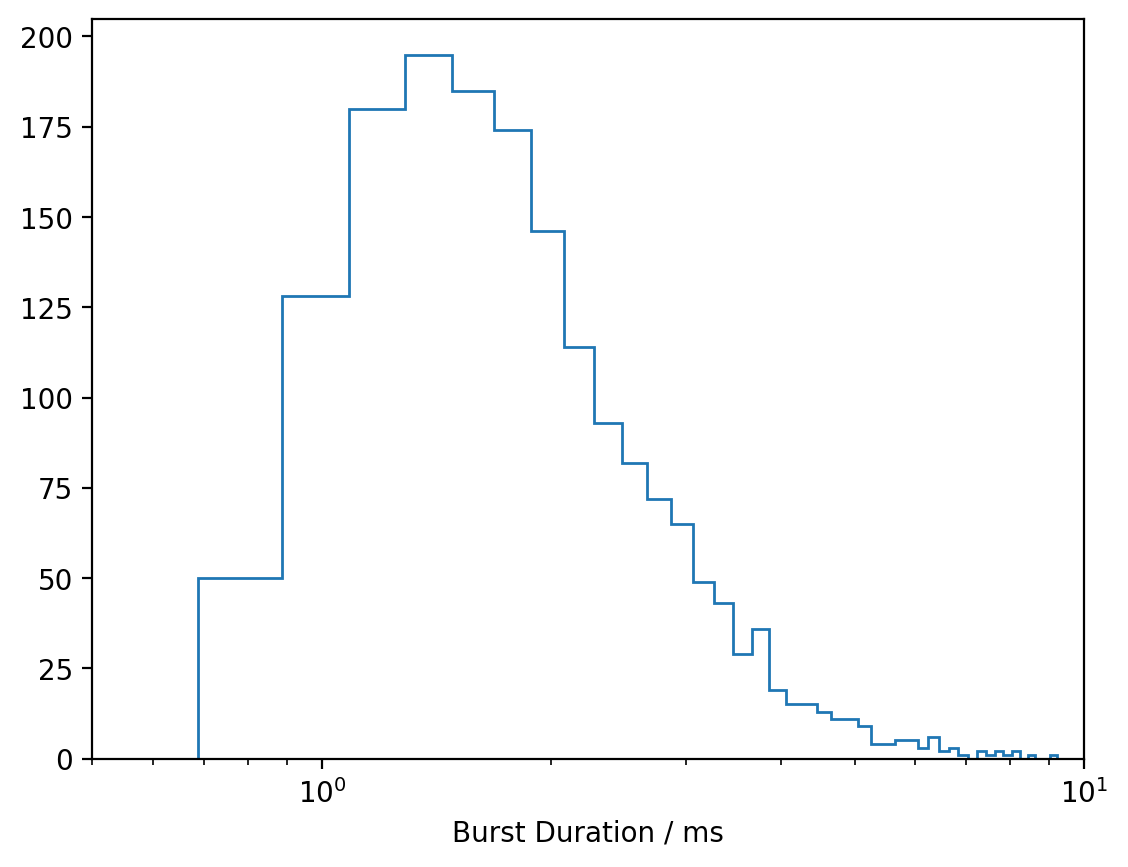

Total number of bursts / s: 35.054
Longest burst duration is 10.607499999999998 ms.


In [194]:
bur_dur = ds.burst_widths[0]
print(f"Average burst duration in ms: {np.mean(bur_dur)*1000}")

plt.hist(bur_dur * 1000, bins = 50, histtype = u"step")
#plt.xscale("log")
plt.xlim(0.5, 10)
plt.xlabel("Burst Duration / ms")
plt.xscale("log")
plt.show()

num_bursts_total = d.E[0].shape[0]
num_bursts_filtered = ds.E[0].shape[0]

print(f"Total number of bursts / s: {num_bursts_total/(d.acquisition_duration)}")
print(f"Longest burst duration is {max(bur_dur*1000)} ms.")

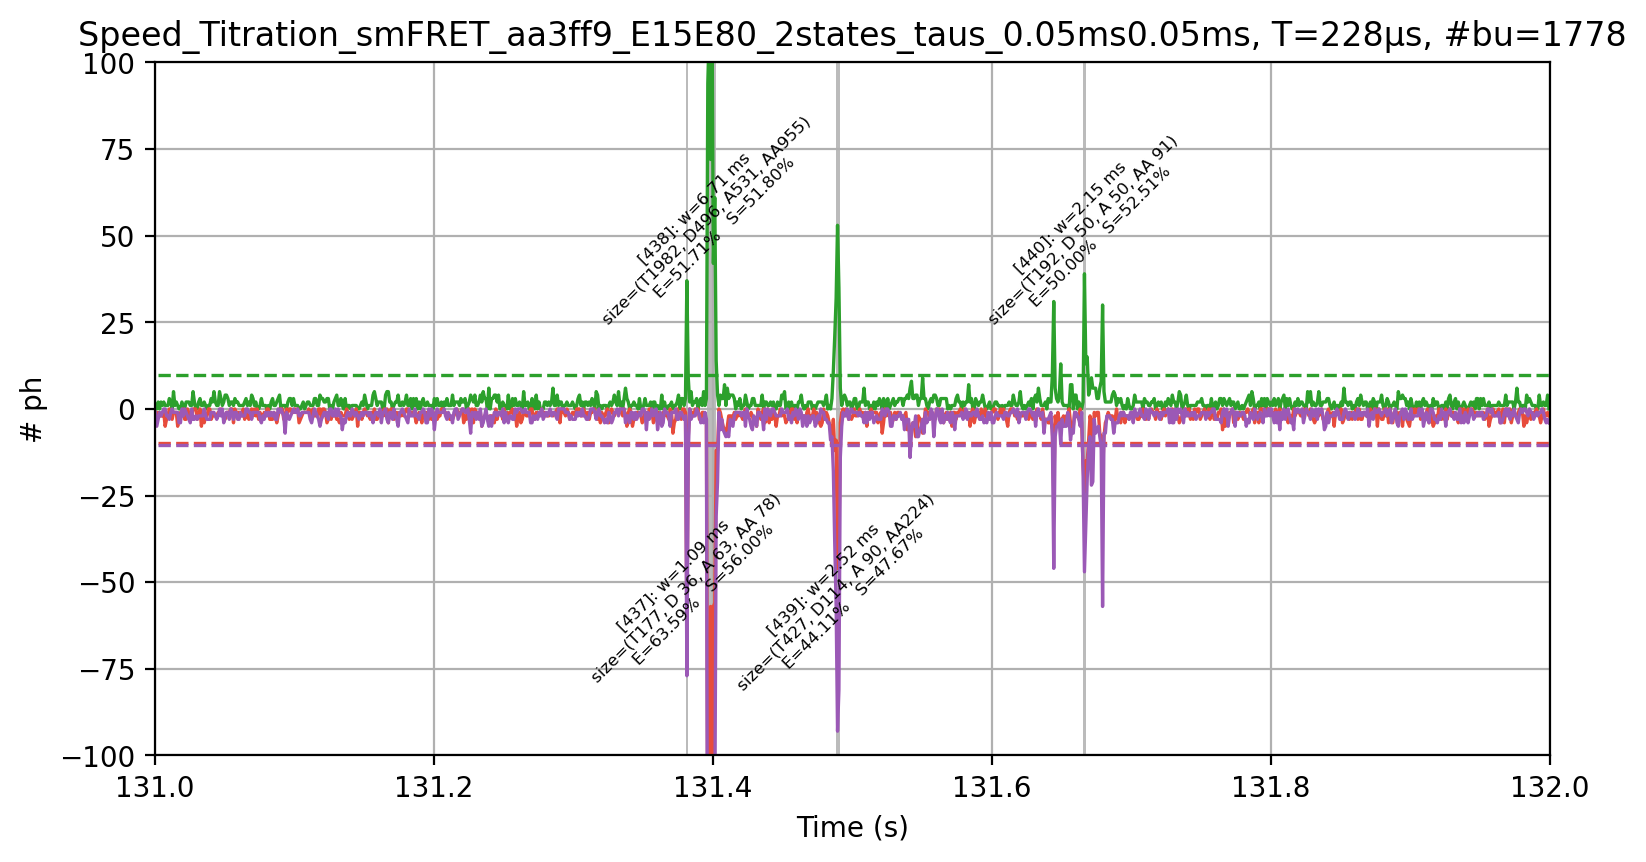

In [195]:
t_trace = 131
fb.dplot(ds, fb.timetrace, tmin=t_trace, tmax=t_trace+1, bursts=True);

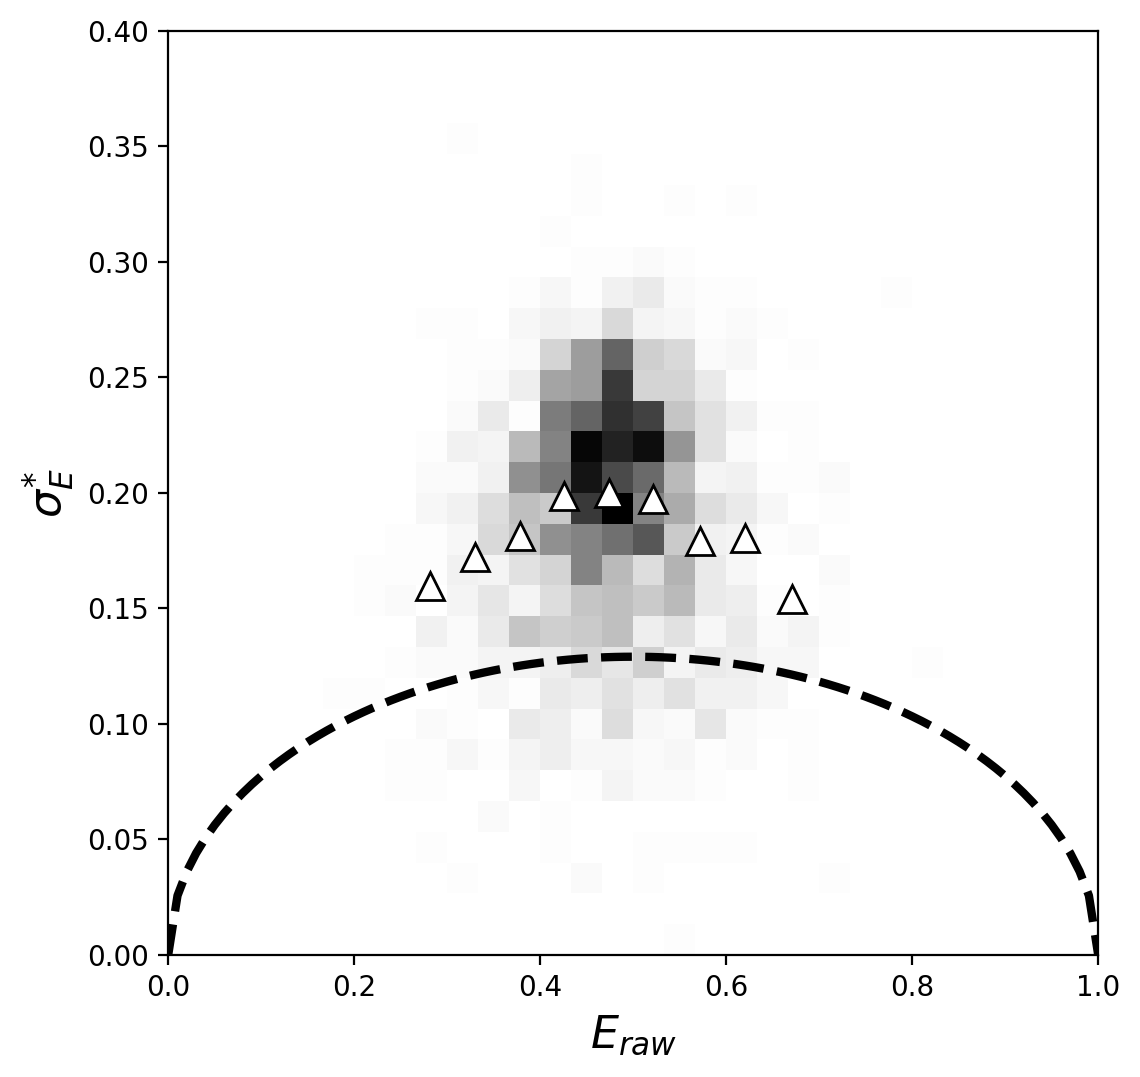

In [196]:
# Plot BVA
R = 20
n = 15
B_Thr = 20

E_da, std_da = BVA(ds, n)
E_da_bin, std_da_bin = bin_bva(E_da, std_da, R, B_Thr)
E_da, std_da = np.concatenate(E_da), np.concatenate(std_da)
plt.figure(figsize=(6,6))
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
plt.plot(x_T,y_T, lw=3, color='k', ls='--')
plt.plot (E_da_bin , std_da_bin, marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
plt.xlim(-0.01,1.01)
plt.ylim(0,0.4)
plt.hist2d(E_da, std_da, cmap = 'Greys', bins = (30, 30), range = ((0, 1), (0, 0.4)))
plt.xlabel(r'$E_{raw}$', fontsize=16)
plt.ylabel('$\sigma_{E}^{*}$', fontsize=16)
#plt.title(r'Simulation: $\tau_{A \leftrightarrow B} = 100 \ \mu s$')
plt.show()

In [197]:
mp = bhm.BurstData(ds)

In [198]:
mp.models.calc_models(to_state=4, max_iter = 800)

The model converged after 1 iterations

The model converged after 137 iterations

Optimization reached maximum number of iterations

Optimization reached maximum number of iterations

0

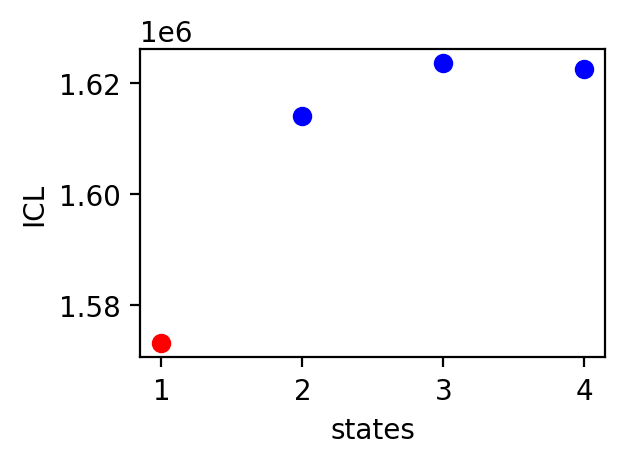

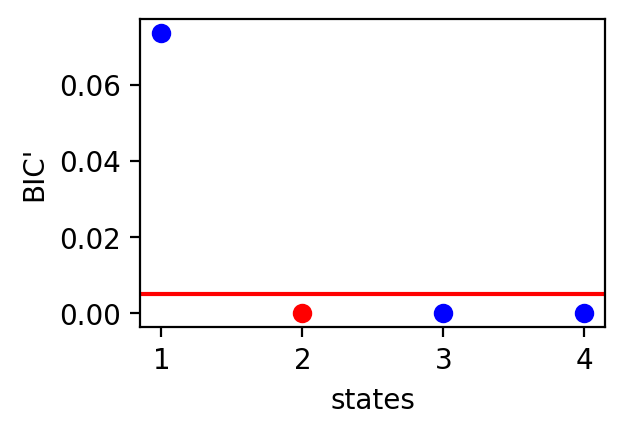

In [199]:
plt.figure(figsize=(3, 2))
mp.models.find_ideal('ICL', auto_set=True)
bhm.ICL_plot(mp.models, highlight_ideal=True)
plt.show()

plt.figure(figsize=(3, 2))
mp.models.find_ideal('BICp', auto_set=True)
bhm.BICp_plot(mp.models, highlight_ideal=True)
plt.axhline(0.005, c = "r")
plt.show()

## Two-State Model

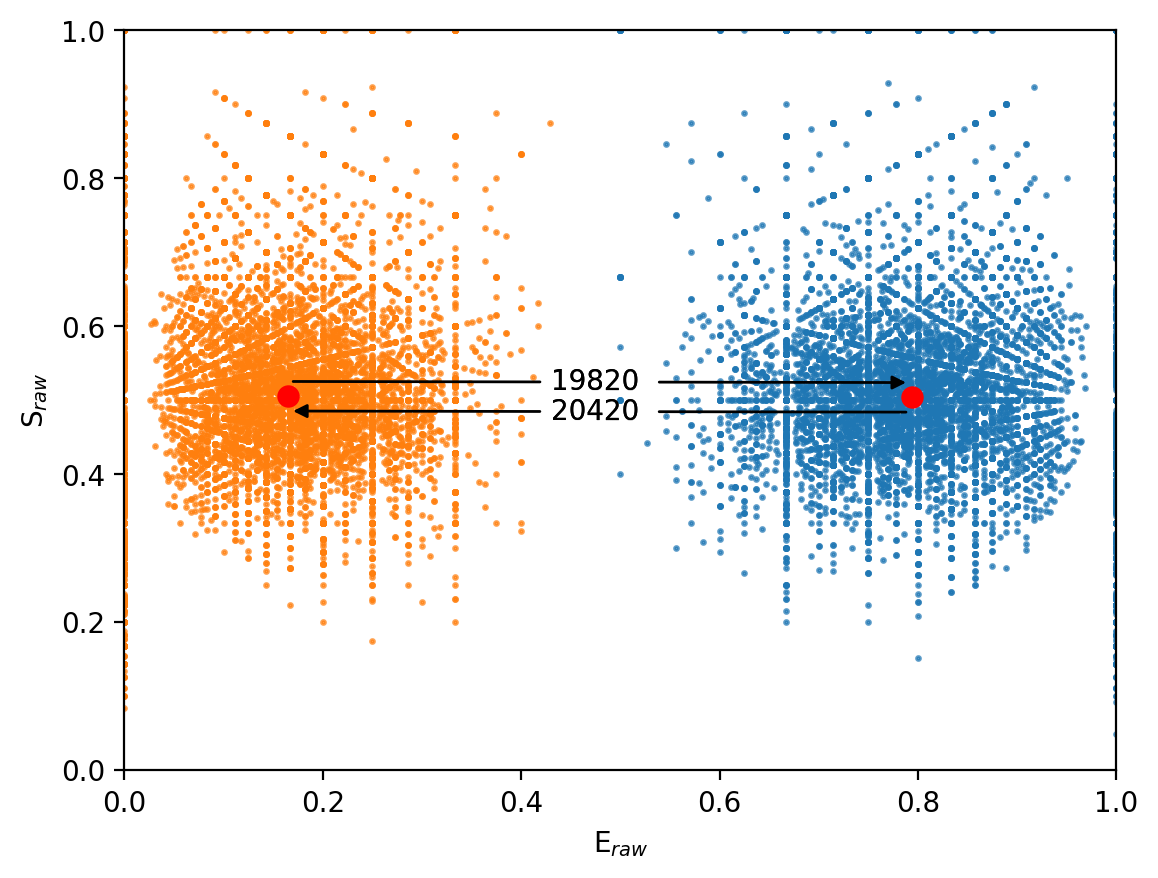

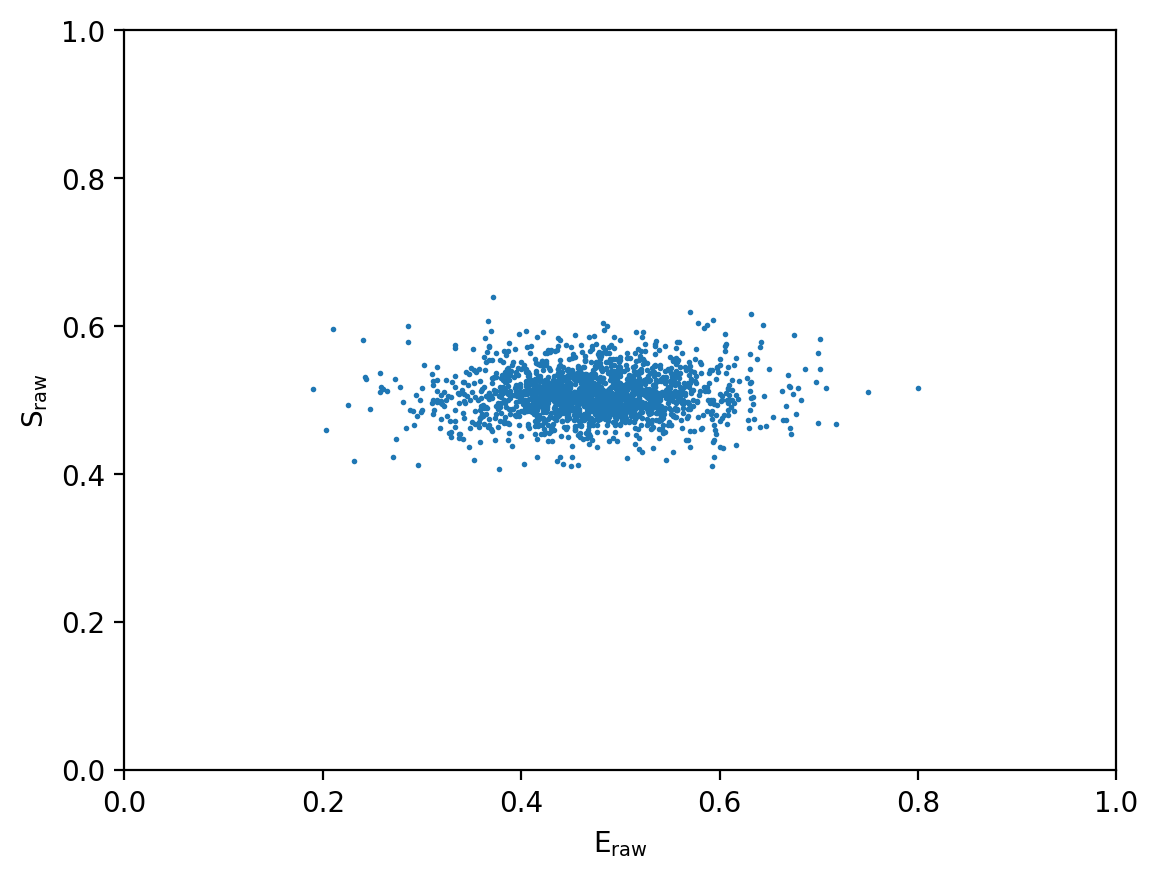

/opt/miniconda3/envs/pybromo/lib/python3.9/site-packages/burstH2MM/BurstSort.py:1836: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  style_frame[f'to_state_{t}'][f'state_{f}'] = 'background-color: lightcoral'


,E_raw,S_raw,to_state_0,to_state_1
state_0,0.793470,0.503655,19979580.345063,20419.654937
state_1,0.164380,0.505129,19819.646767,19980180.353233


In [200]:
model_id = 1

bhm.dwell_ES_scatter(mp.models[model_id], s = 2)
bhm.trans_arrow_ES(mp.models[model_id], min_rate = 1)
#bhm.axline_E(mp.models[model_id])
bhm.scatter_ES(mp.models[model_id], s = 50, color = "r")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

bhm.burst_ES_scatter(mp.models[model_id], flatten_dynamics=False, s = 1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

mp.models[model_id]

## Three-State Model

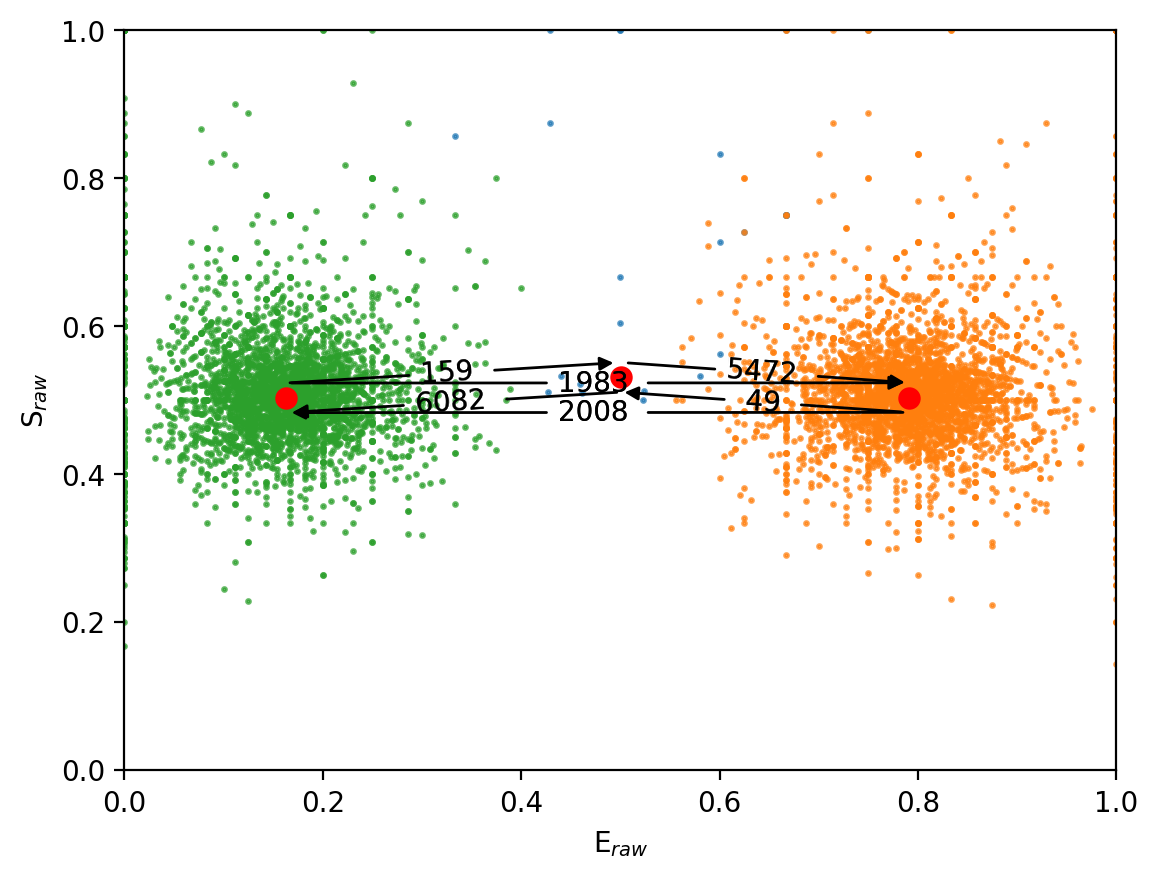

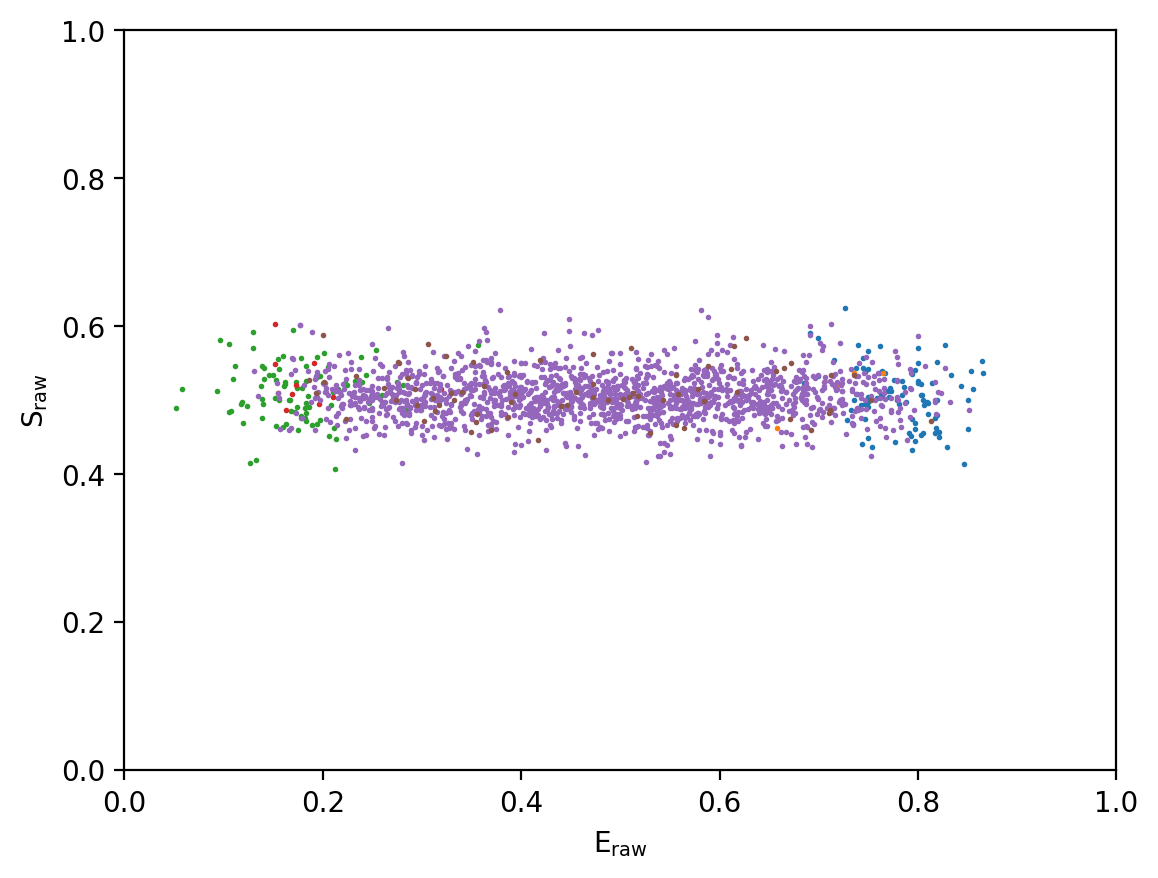

/opt/miniconda3/envs/pybromo/lib/python3.9/site-packages/burstH2MM/BurstSort.py:1836: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  style_frame[f'to_state_{t}'][f'state_{f}'] = 'background-color: lightcoral'


,E_raw,S_raw,to_state_0,to_state_1,to_state_2
state_0,0.500277,0.530820,19988445.874640,5472.078165,6082.047195
state_1,0.790382,0.503311,48.643471,19997943.649045,2007.707485
state_2,0.162890,0.502992,159.379364,1983.287018,19997857.333618


In [158]:
model_id = 2

bhm.dwell_ES_scatter(mp.models[model_id], s = 2)
bhm.trans_arrow_ES(mp.models[model_id], min_rate = 1)
#bhm.axline_E(mp.models[model_id])
bhm.scatter_ES(mp.models[model_id], s = 50, color = "r")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

bhm.burst_ES_scatter(mp.models[model_id], flatten_dynamics=False, s = 1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

mp.models[model_id]

## Four-State Model

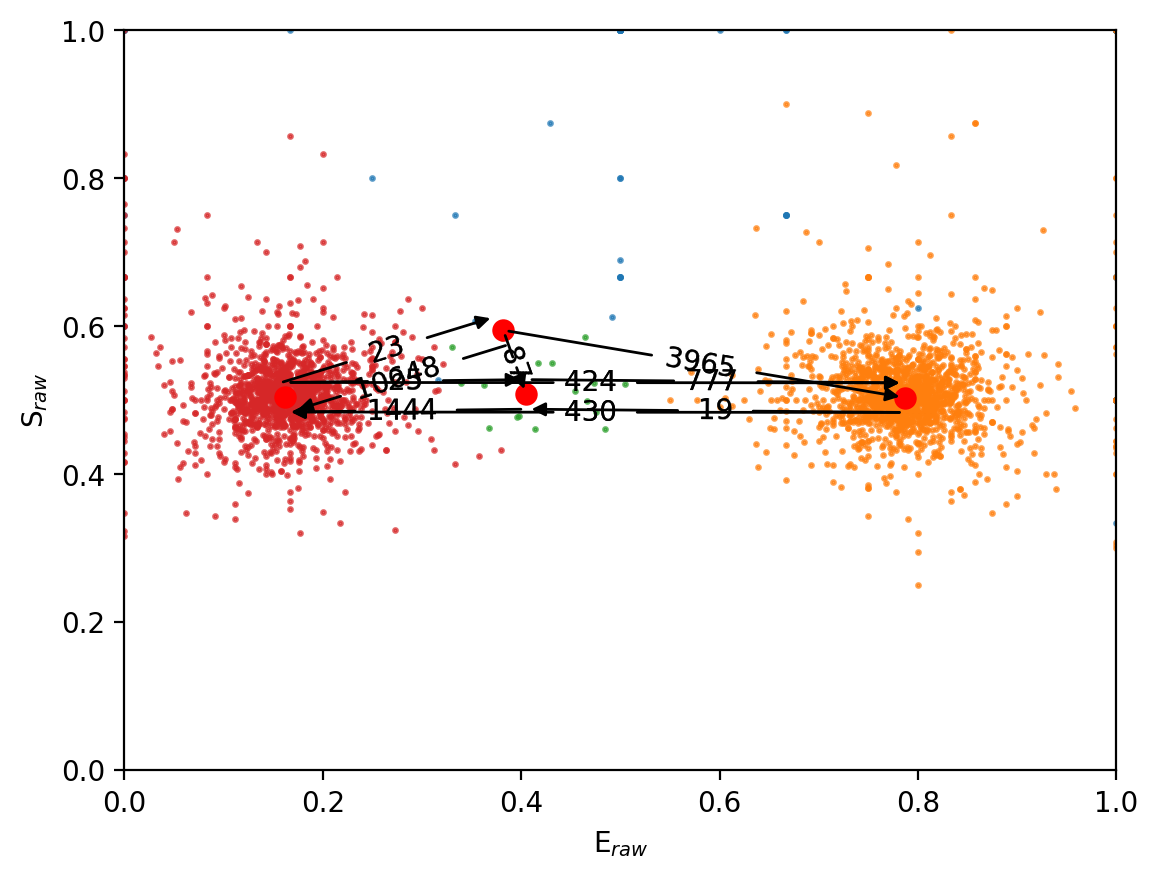

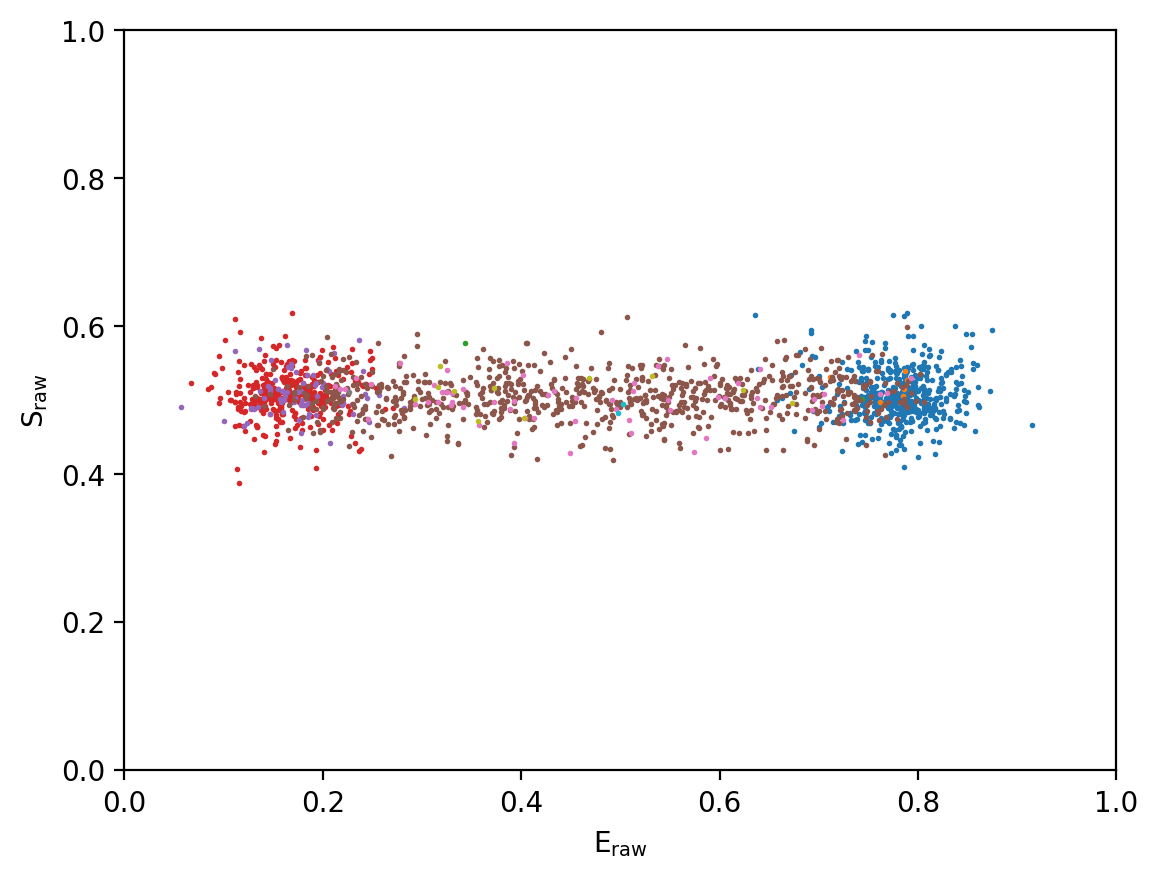

/opt/miniconda3/envs/pybromo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/pybromo/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/envs/pybromo/lib/python3.9/site-packages/burstH2MM/BurstSort.py:1836: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = valu

,E_raw,S_raw,to_state_0,to_state_1,to_state_2,to_state_3
state_0,0.381874,0.594428,19985299.493891,3965.489279,86.841148,10648.175682
state_1,0.786849,0.503250,0.000000,19999550.466443,19.117327,430.416230
state_2,0.404904,0.507623,0.000293,776.782886,19997779.224827,1443.991994
state_3,0.162287,0.503820,22.561111,423.807762,24.964400,19999528.666727


In [120]:
model_id = 3

bhm.dwell_ES_scatter(mp.models[model_id], s = 2)
bhm.trans_arrow_ES(mp.models[model_id], min_rate = 1)
#bhm.axline_E(mp.models[model_id])
bhm.scatter_ES(mp.models[model_id], s = 50, color = "r")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

bhm.burst_ES_scatter(mp.models[model_id], flatten_dynamics=False, s = 1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

mp.models[model_id]

## Five-State Model

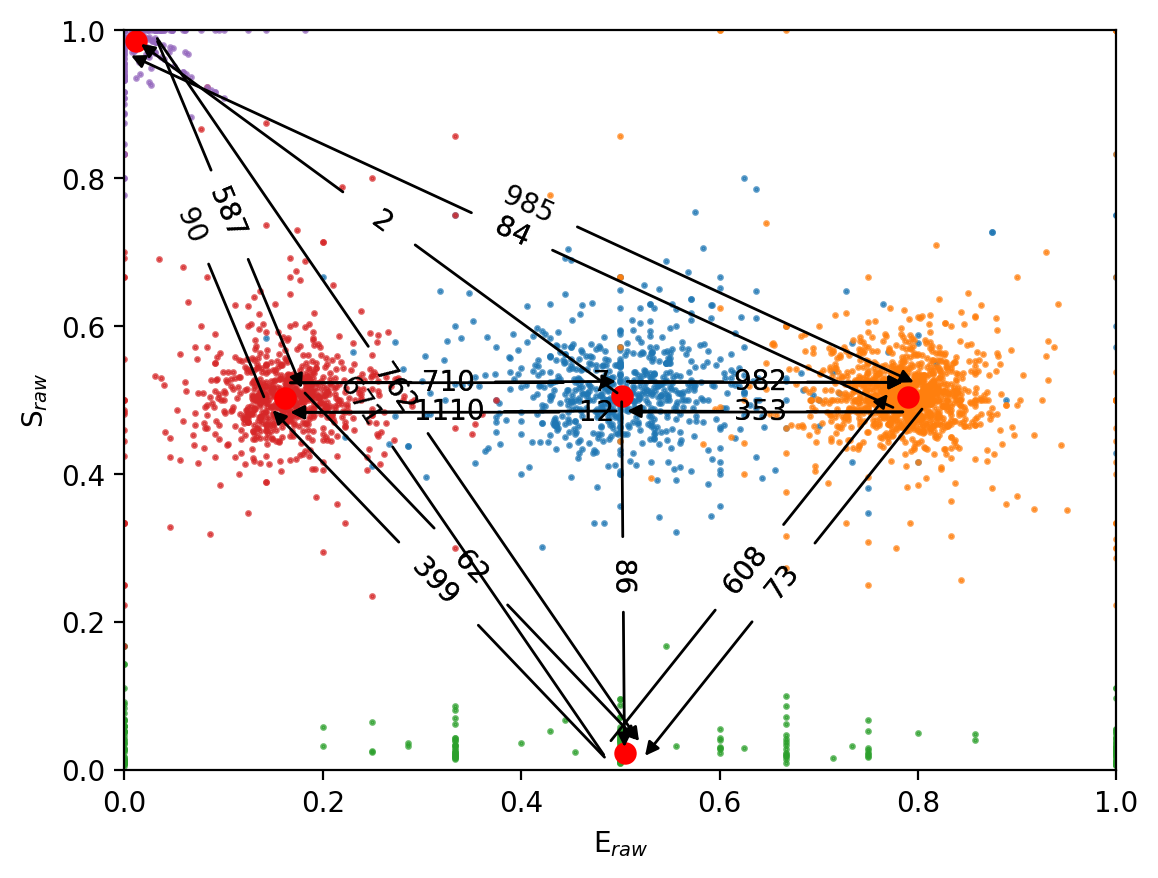

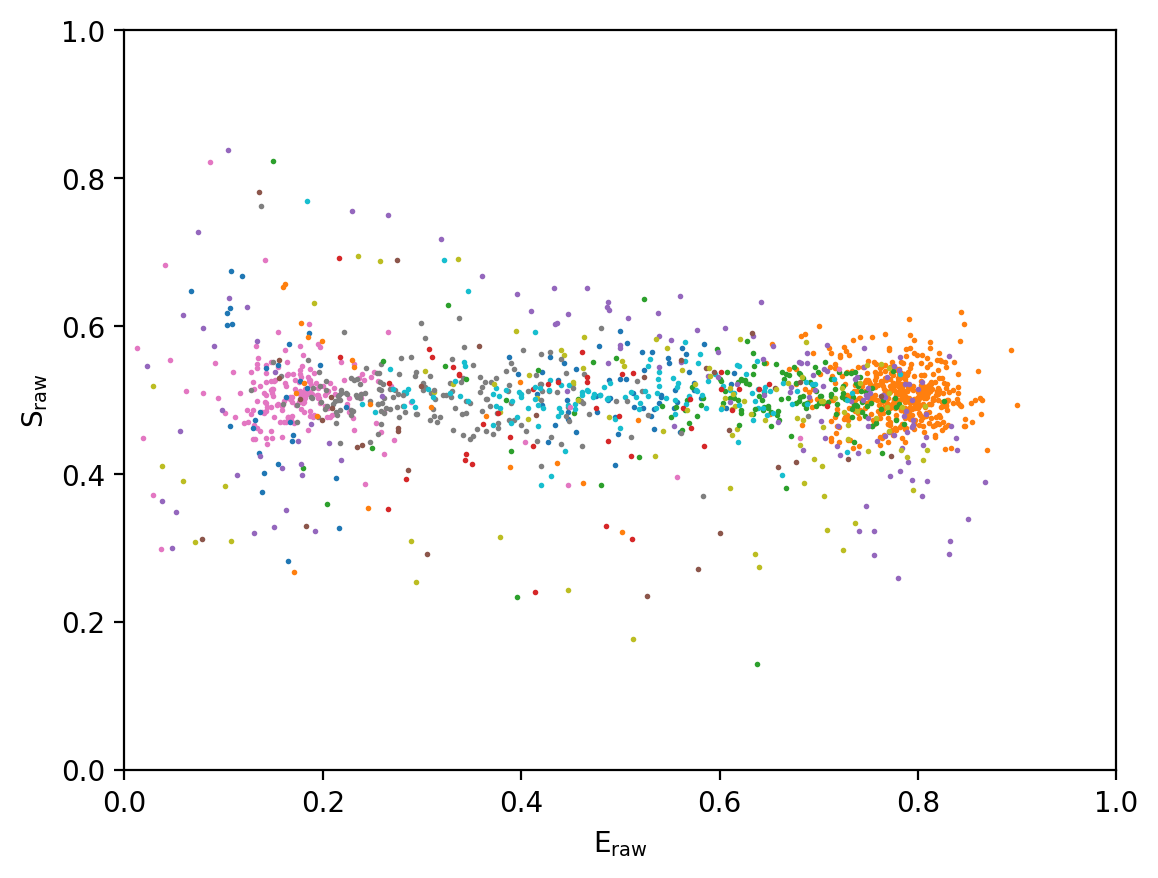

/opt/miniconda3/envs/pybromo/lib/python3.9/site-packages/burstH2MM/BurstSort.py:1836: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  style_frame[f'to_state_{t}'][f'state_{f}'] = 'background-color: lightcoral'
/opt/miniconda3/envs/pybromo/lib/

,E_raw,S_raw,to_state_0,to_state_1,to_state_2,to_state_3,to_state_4
state_0,0.501162,0.505208,19997819.597466,981.895737,86.492990,1110.279124,1.734684
state_1,0.790258,0.503903,353.496732,19999476.821188,72.730371,12.458093,84.493615
state_2,0.504053,0.023037,0.044180,607.511451,19998322.040130,399.315261,671.088979
state_3,0.161755,0.503332,709.995510,6.888474,61.587623,19999131.606001,89.922392
state_4,0.012047,0.986204,0.000000,985.171316,762.380214,587.256180,19997665.192290


In [12]:
model_id = 4

bhm.dwell_ES_scatter(mp.models[model_id], s = 2)
bhm.trans_arrow_ES(mp.models[model_id], min_rate = 1)
#bhm.axline_E(mp.models[model_id])
bhm.scatter_ES(mp.models[model_id], s = 50, color = "r")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

bhm.burst_ES_scatter(mp.models[model_id], flatten_dynamics=False, s = 1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

mp.models[model_id]

### Selecting from the Three-State Model, selecting the FRET-states 0 and 2

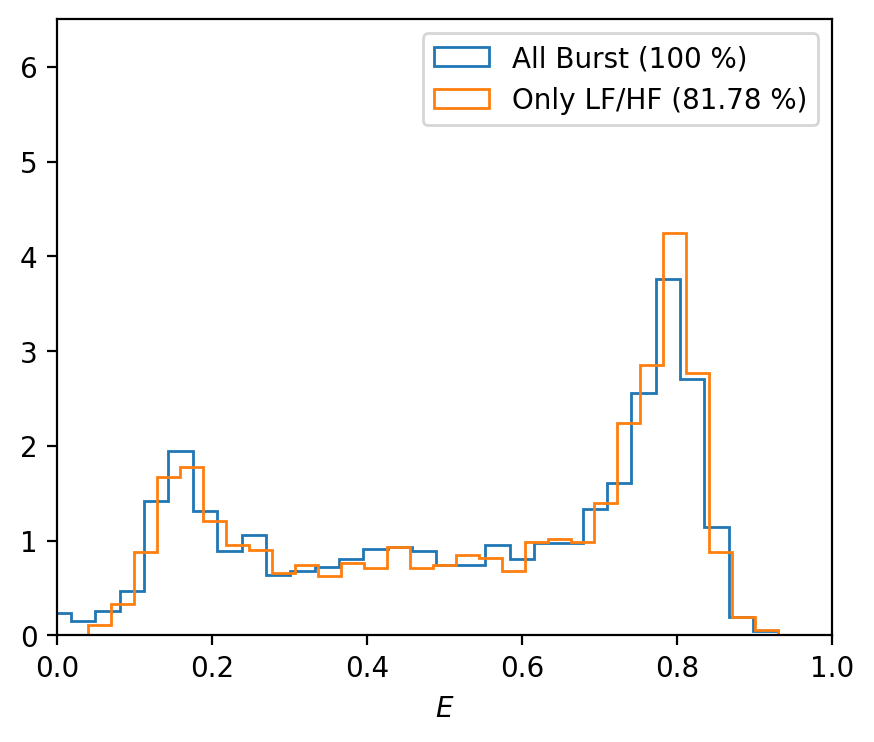

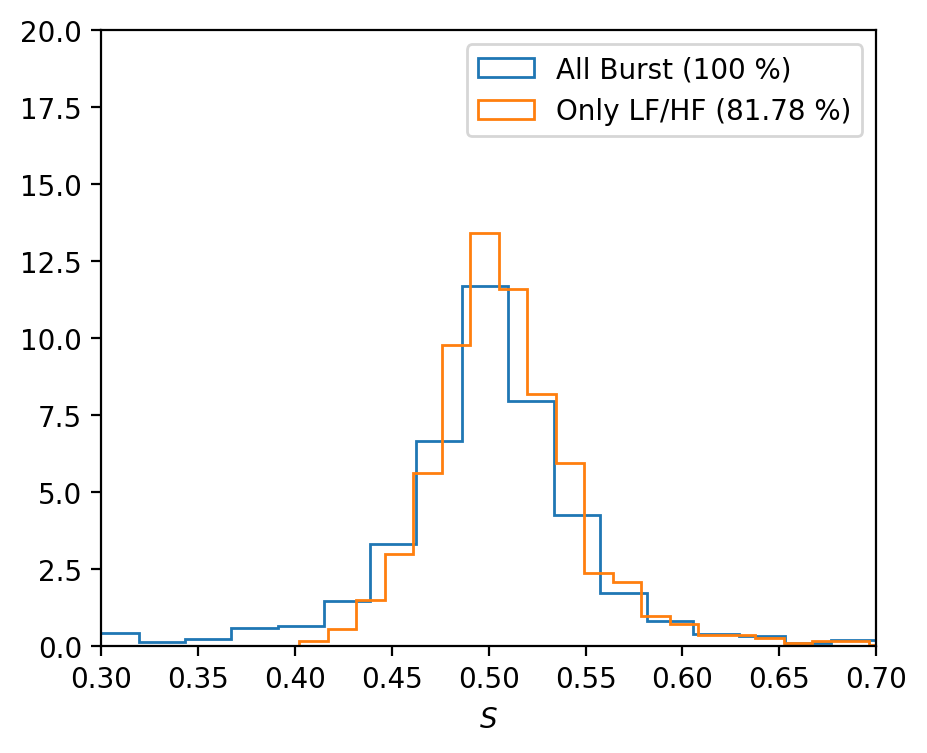

Selected 1230 out of 1504 bursts: 81.78191489361703 %.


In [13]:
# Burst Purification Approach: see https://drive.google.com/file/d/1RlG_ELupM9DD4lyYAD4INpa_qjWib55X/view?usp=drive_link
# and 'exclusivity analysis' - see if a dwell contains mostly static bursts

model_id = 2

total_bursts = len(ds.E[0])

# Selecting bursts that visited the LF or HF state but never a dye blinking state!
sel_idxs = np.where((mp.models[model_id].burst_type == int(0b001)) | (mp.models[model_id].burst_type == int(0b100)) | (mp.models[model_id].burst_type == int(0b101)))

plt.subplots(figsize=(5, 4))
plt.hist(ds.E[0], bins = 30, alpha = 1.0, label = f"All Burst (100 %)", density=True, histtype=u'step')
plt.hist(ds.E[0][sel_idxs], bins = 30, alpha = 1.0, label = f"Only LF/HF ({round((len(ds.E[0][sel_idxs])/total_bursts) * 100, 2)} %)", density=True, histtype=u'step')
plt.legend(loc = "best")
plt.xlim(0, 1)
plt.ylim(0, 6.5)
plt.xlabel(r"$E$")
#plt.savefig("../../manuscript/figures/figure_burstpurification/figure_burstpurification.svg")
#plt.savefig("../../manuscript/figures/figure_burstpurification/figure_burstpurification.svg")
plt.show()


plt.subplots(figsize=(5, 4))
plt.hist(ds.S[0], bins = 30, alpha = 1.0, label = f"All Burst (100 %)", density=True, histtype=u'step')
plt.hist(ds.S[0][sel_idxs], bins = 30, alpha = 1.0, label = f"Only LF/HF ({round((len(ds.E[0][sel_idxs])/total_bursts) * 100, 2)} %)", density=True, histtype=u'step')
plt.legend(loc = "best")
plt.xlim(0.3, 0.7)
plt.ylim(0, 20)
plt.xlabel(r"$S$")
#plt.savefig("../../manuscript/figures/figure_burstpurification/figure_burstpurification.svg")
#plt.savefig("../../manuscript/figures/figure_burstpurification/figure_burstpurification.svg")
plt.show()



print(f'Selected {len(ds.E[0][sel_idxs])} out of {total_bursts} bursts: {len(ds.E[0][sel_idxs])/total_bursts * 100} %.')

<class 'matplotlib.figure.Figure'>


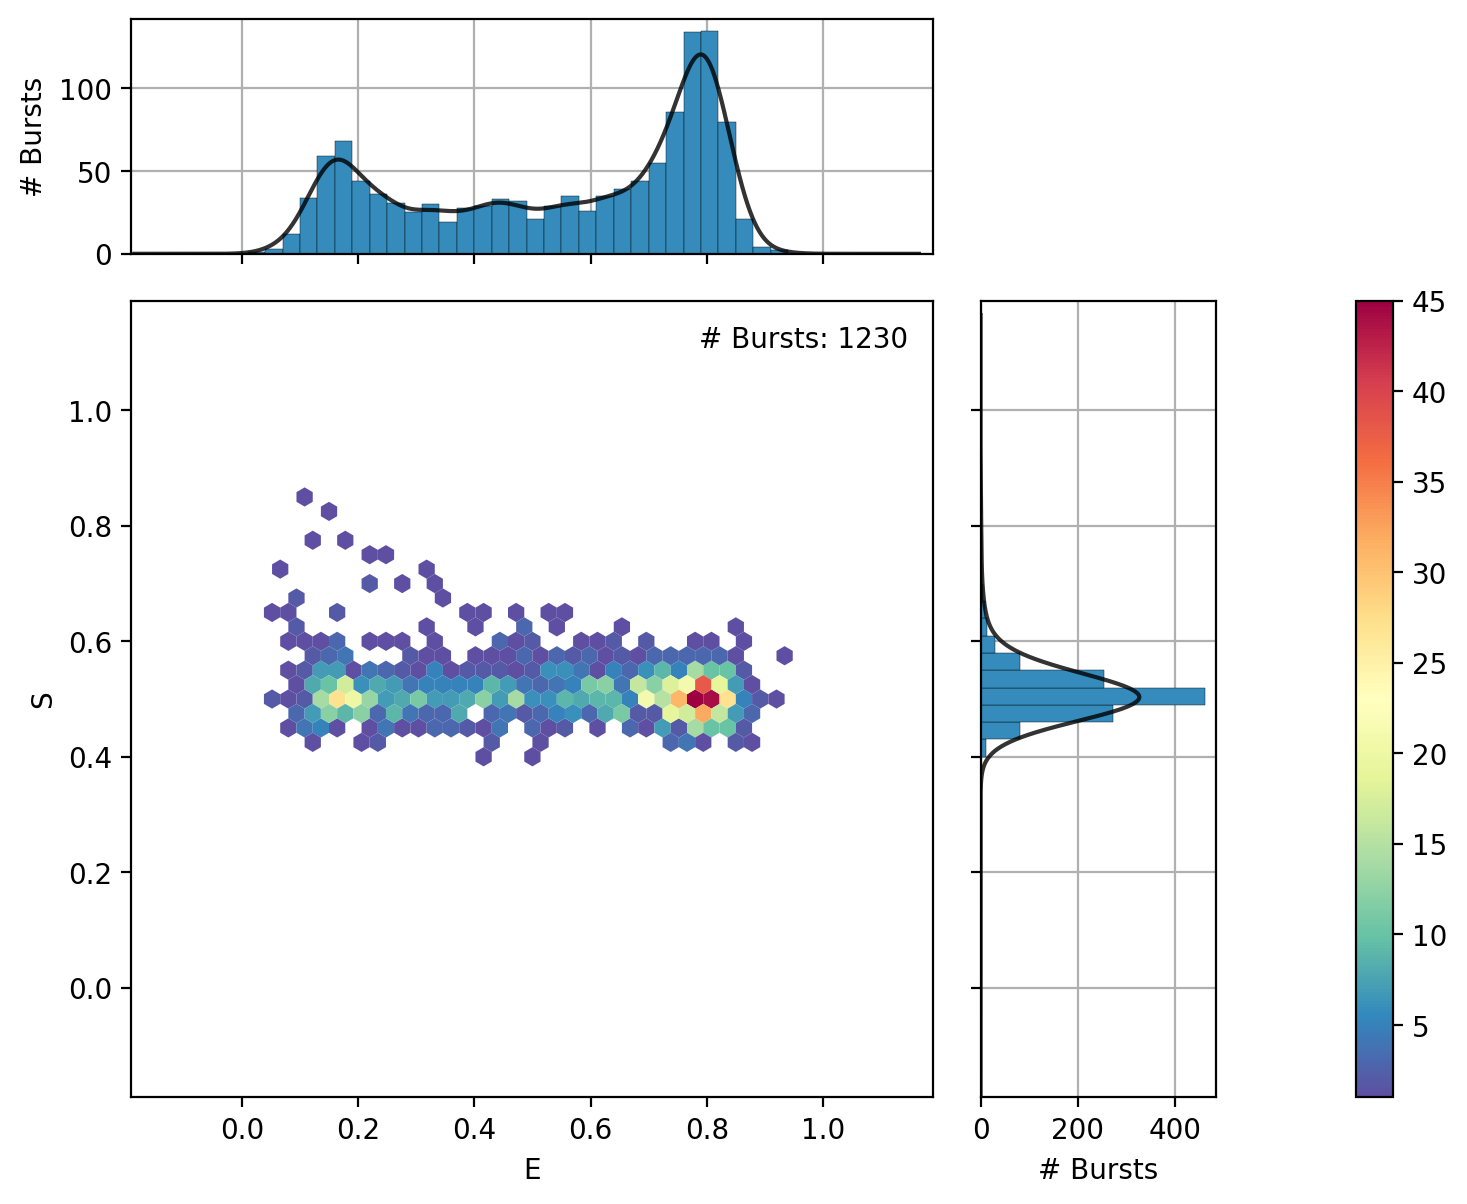

In [14]:
# Selecting bursts and make new fretbursts object
ds_sel = ds.select_bursts_mask_apply(sel_idxs)
fb.alex_jointplot(ds_sel);

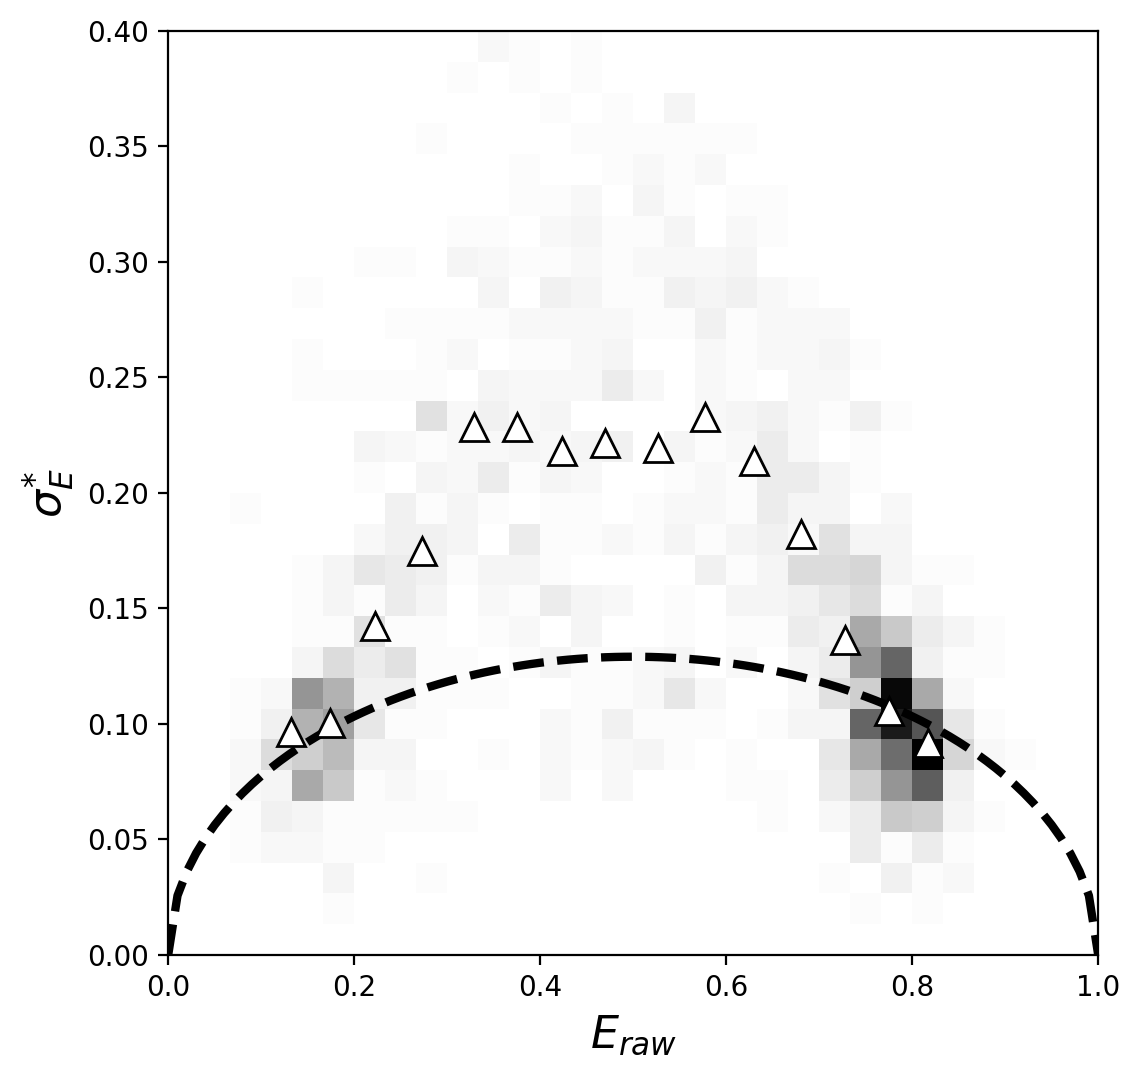

In [15]:
# Plot BVA
R = 20
n = 15
B_Thr = 20

E_da, std_da = BVA(ds_sel, n)
E_da_bin, std_da_bin = bin_bva(E_da, std_da, R, B_Thr)
E_da, std_da = np.concatenate(E_da), np.concatenate(std_da)
plt.figure(figsize=(6,6))
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
plt.plot(x_T,y_T, lw=3, color='k', ls='--')
plt.plot (E_da_bin , std_da_bin, marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
plt.xlim(-0.01,1.01)
plt.ylim(0,0.4)
plt.hist2d(E_da, std_da, cmap = 'Greys', bins = (30, 30), range = ((0, 1), (0, 0.4)))
plt.xlabel(r'$E_{raw}$', fontsize=16)
plt.ylabel('$\sigma_{E}^{*}$', fontsize=16)
#plt.title(r'Simulation: $\tau_{A \leftrightarrow B} = 100 \ \mu s$')
plt.show()

In [17]:
mp_sel = bhm.BurstData(ds_sel)

mp_sel.models.calc_models(max_iter = 3600, to_state=5)

The model converged after 1 iterations

The model converged after 47 iterations

The model converged after 185 iterations

The model converged after 268 iterations

The model converged after 580 iterations

2

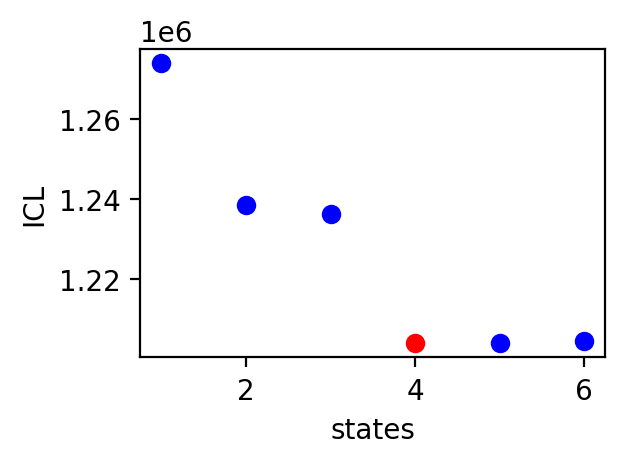

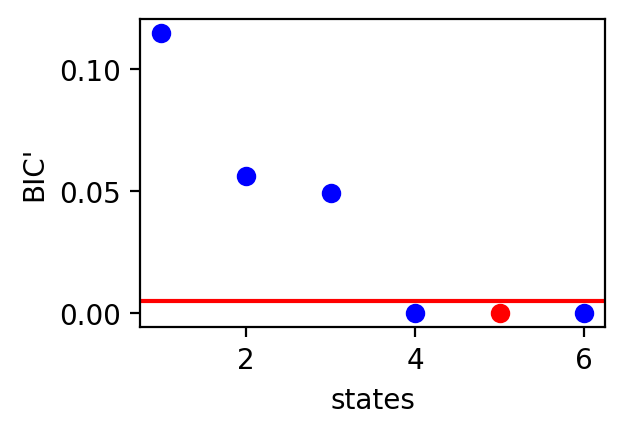

In [18]:
plt.figure(figsize=(3, 2))
mp.models.find_ideal('ICL', auto_set=True)
bhm.ICL_plot(mp.models, highlight_ideal=True)
plt.show()

plt.figure(figsize=(3, 2))
mp.models.find_ideal('BICp', auto_set=True)
bhm.BICp_plot(mp.models, highlight_ideal=True)
plt.axhline(0.005, c = "r")
plt.show()

In [19]:
mp_sel.models[2]

/opt/miniconda3/envs/pybromo/lib/python3.9/site-packages/burstH2MM/BurstSort.py:1836: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  style_frame[f'to_state_{t}'][f'state_{f}'] = 'background-color: lightcoral'
/opt/miniconda3/envs/pybromo/lib/

,E_raw,S_raw,to_state_0,to_state_1,to_state_2
state_0,0.012959,0.981773,19997775.805682,903.277827,1320.916491
state_1,0.499044,0.505118,64.673780,19999928.085012,7.241208
state_2,0.307955,0.502836,82.085230,8.335430,19999909.579340


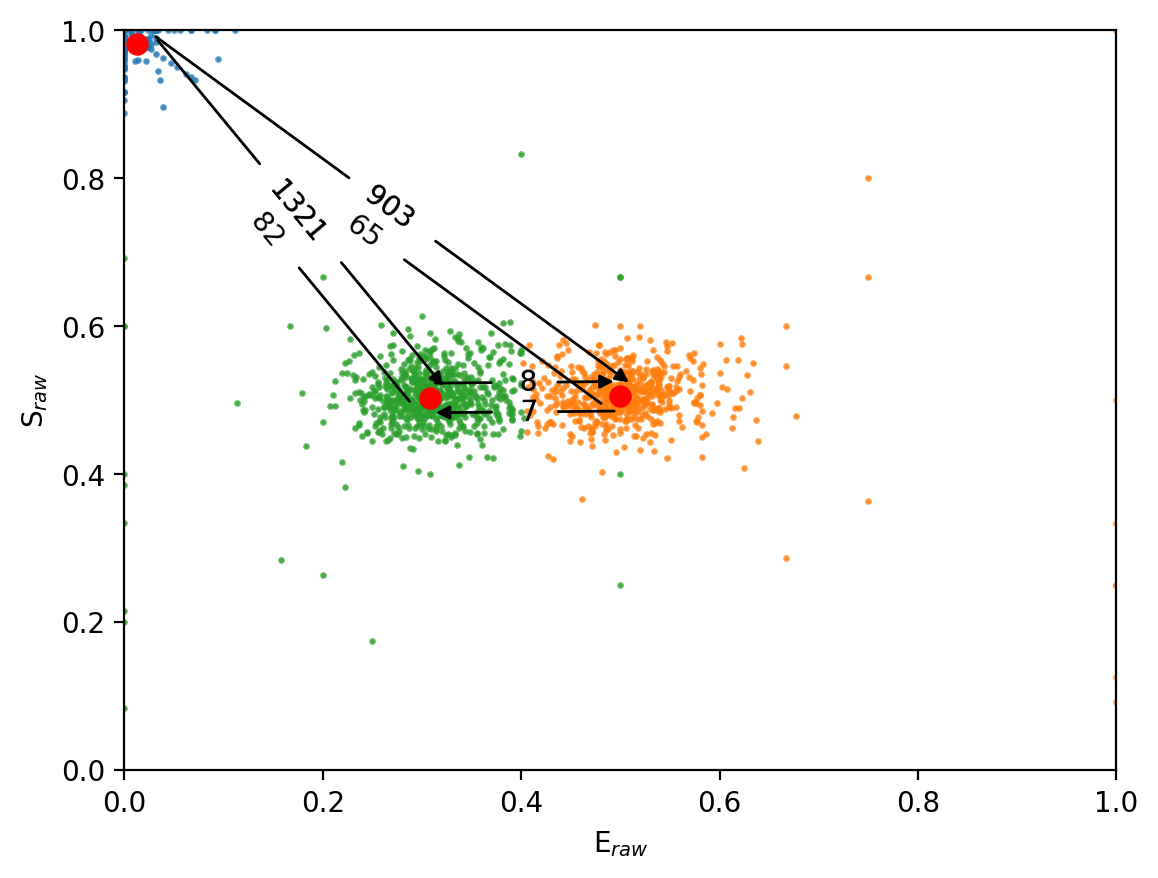

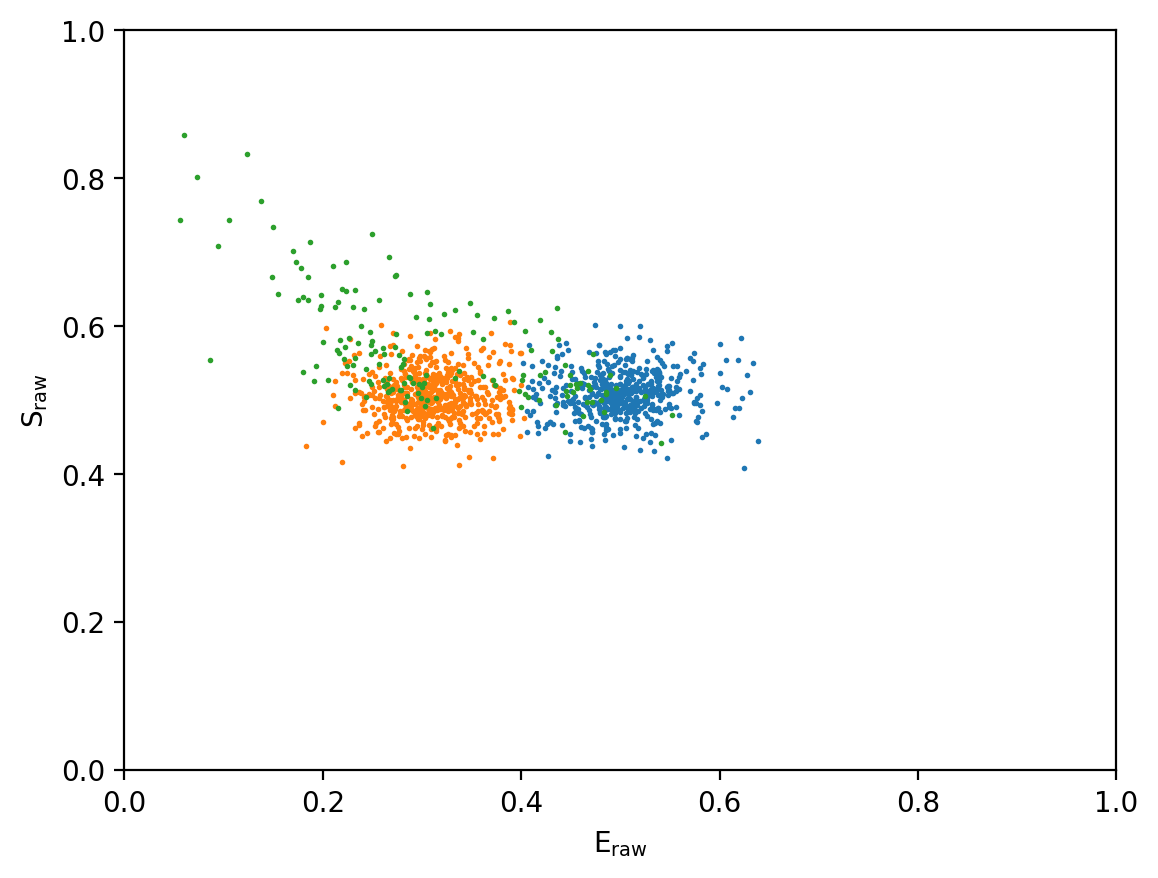

In [20]:
model_id = 2

bhm.dwell_ES_scatter(mp_sel.models[model_id], s = 2)
bhm.trans_arrow_ES(mp_sel.models[model_id], min_rate=1)
#bhm.axline_E(mp.models[model_id])
bhm.scatter_ES(mp_sel.models[model_id], s = 50, color = "r")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

bhm.burst_ES_scatter(mp_sel.models[model_id], flatten_dynamics=True, s = 1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## Selecting from the Four-State Model, selecting the FRET-state 1 and 3

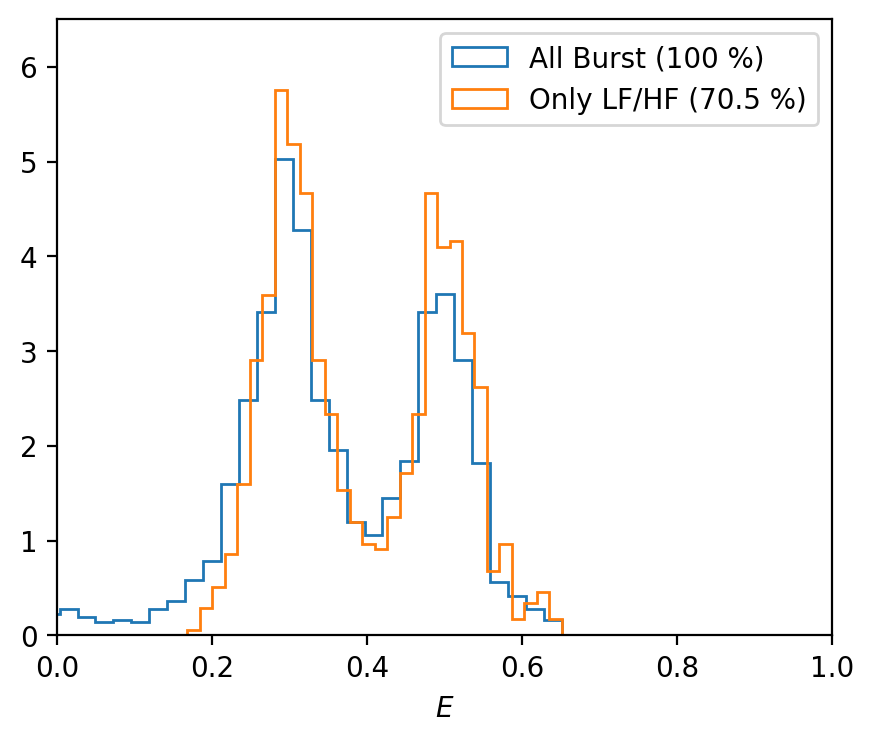

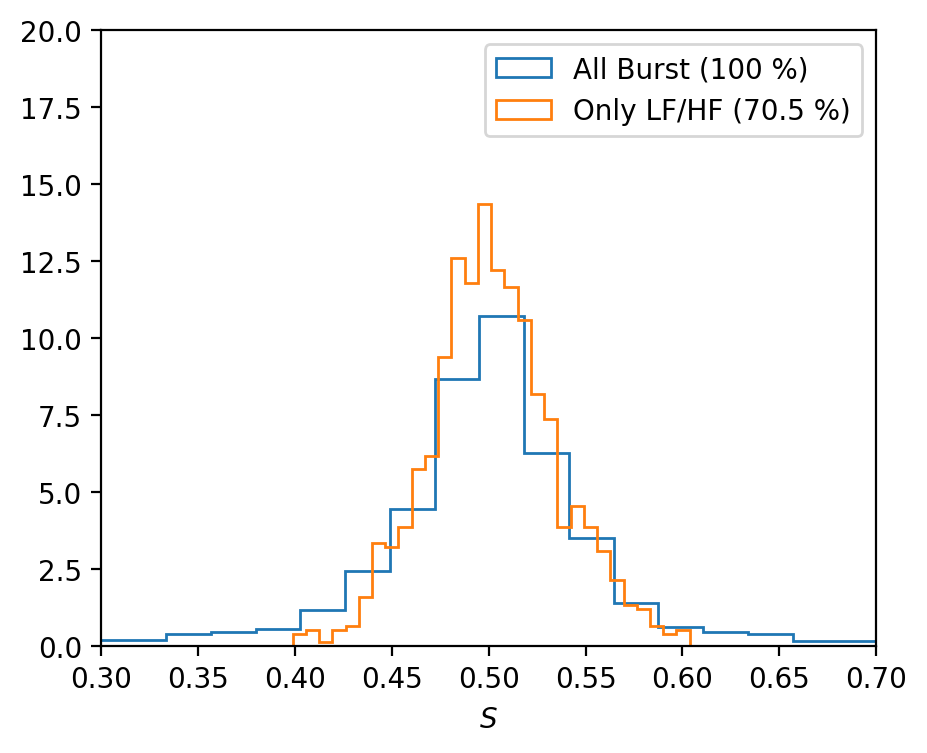

Selected 1090 out of 1546 bursts: 70.5045278137128 %.


In [21]:
# Burst Purification Approach: see https://drive.google.com/file/d/1RlG_ELupM9DD4lyYAD4INpa_qjWib55X/view?usp=drive_link
# and 'exclusivity analysis' - see if a dwell contains mostly static bursts

model_id = 3

total_bursts = len(ds.E[0])

# Selecting bursts that visited the LF or HF state but never a dye blinking state!
sel_idxs = np.where((mp.models[model_id].burst_type == int(0b0010)) | (mp.models[model_id].burst_type == int(0b1000)) | (mp.models[model_id].burst_type == int(0b1010)))

plt.subplots(figsize=(5, 4))
plt.hist(ds.E[0], bins = 30, alpha = 1.0, label = f"All Burst (100 %)", density=True, histtype=u'step')
plt.hist(ds.E[0][sel_idxs], bins = 30, alpha = 1.0, label = f"Only LF/HF ({round((len(ds.E[0][sel_idxs])/total_bursts) * 100, 2)} %)", density=True, histtype=u'step')
plt.legend(loc = "best")
plt.xlim(0, 1)
plt.ylim(0, 6.5)
plt.xlabel(r"$E$")
#plt.savefig("../../manuscript/figures/figure_burstpurification/figure_burstpurification.svg")
#plt.savefig("../../manuscript/figures/figure_burstpurification/figure_burstpurification.svg")
plt.show()


plt.subplots(figsize=(5, 4))
plt.hist(ds.S[0], bins = 30, alpha = 1.0, label = f"All Burst (100 %)", density=True, histtype=u'step')
plt.hist(ds.S[0][sel_idxs], bins = 30, alpha = 1.0, label = f"Only LF/HF ({round((len(ds.E[0][sel_idxs])/total_bursts) * 100, 2)} %)", density=True, histtype=u'step')
plt.legend(loc = "best")
plt.xlim(0.3, 0.7)
plt.ylim(0, 20)
plt.xlabel(r"$S$")
#plt.savefig("../../manuscript/figures/figure_burstpurification/figure_burstpurification.svg")
#plt.savefig("../../manuscript/figures/figure_burstpurification/figure_burstpurification.svg")
plt.show()



print(f'Selected {len(ds.E[0][sel_idxs])} out of {total_bursts} bursts: {len(ds.E[0][sel_idxs])/total_bursts * 100} %.')

<class 'matplotlib.figure.Figure'>
<class 'matplotlib.figure.Figure'>


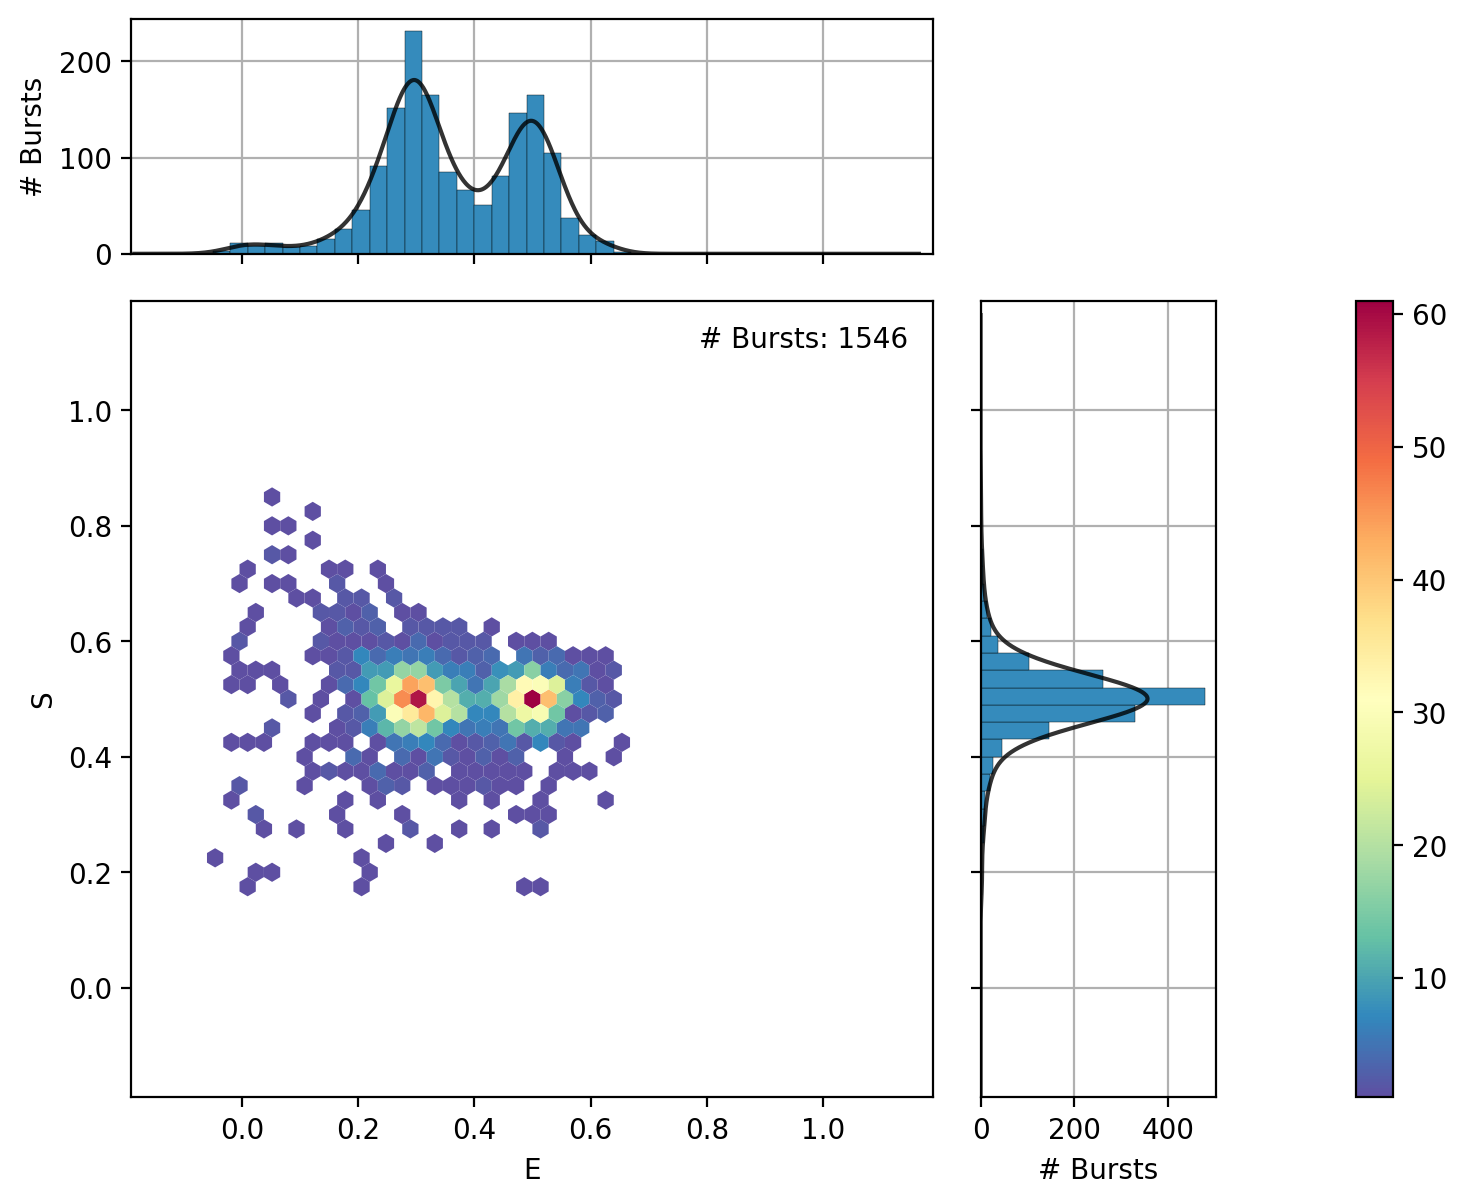

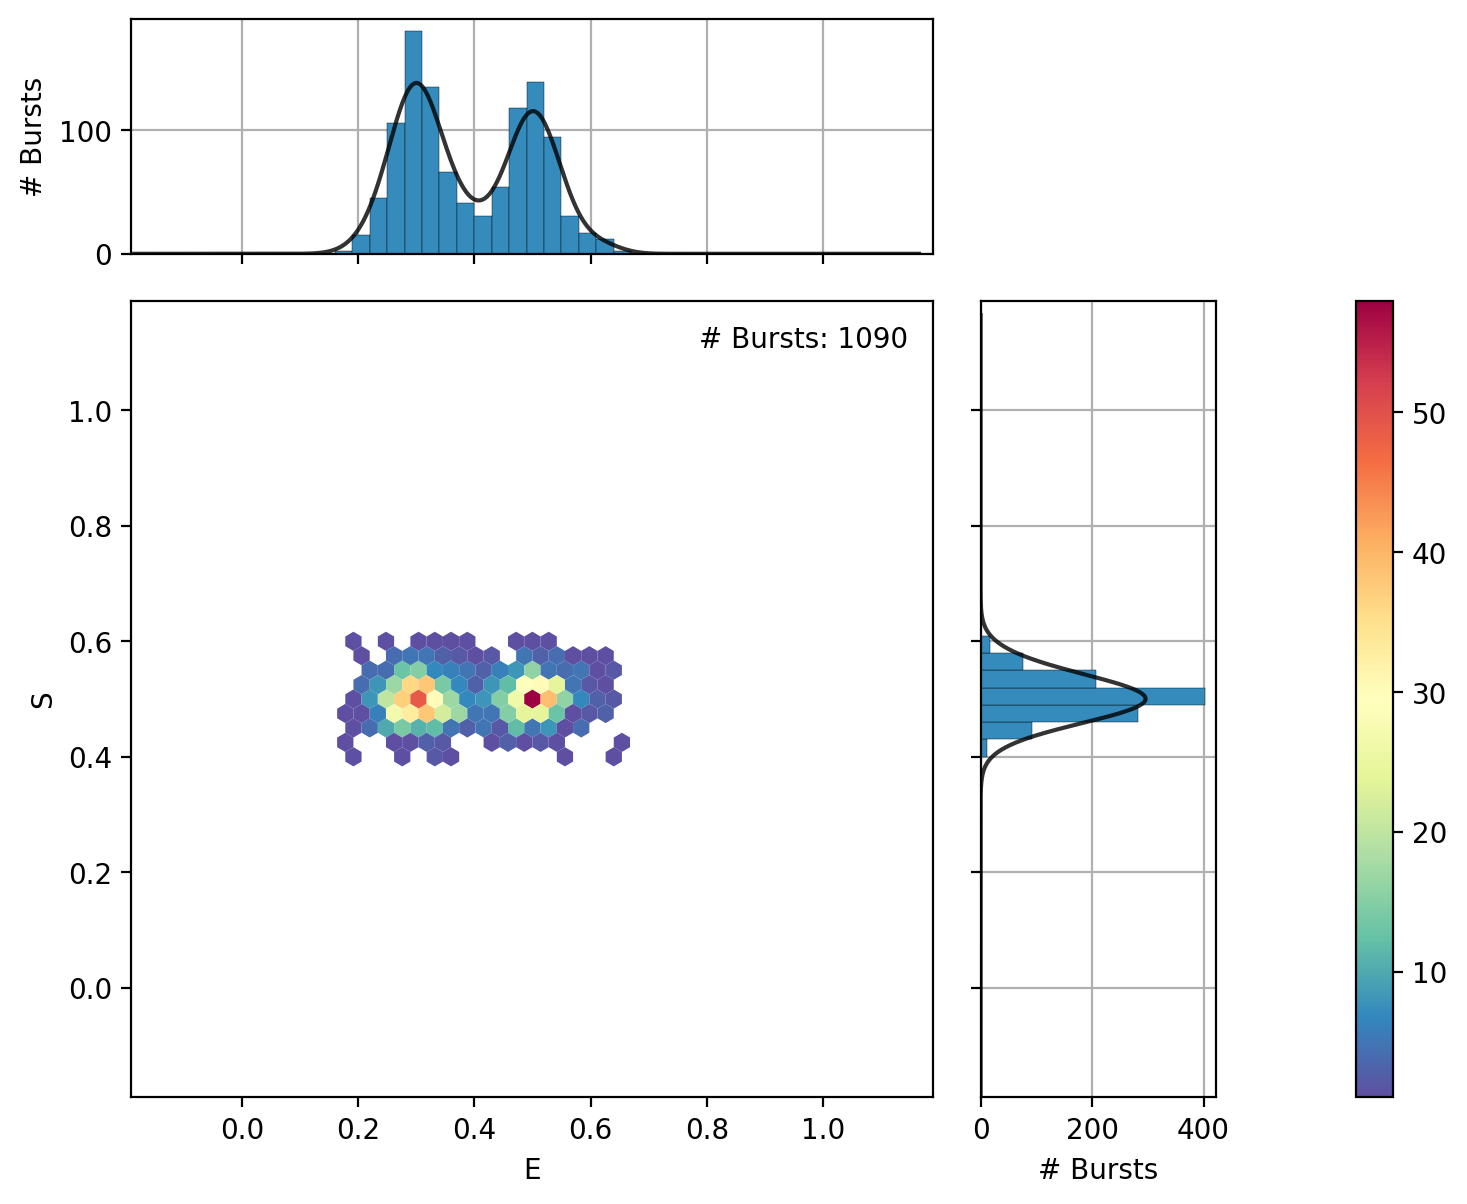

In [22]:
# Selecting bursts and make new fretbursts object
ds_sel = ds.select_bursts_mask_apply(sel_idxs)
fb.alex_jointplot(ds);
fb.alex_jointplot(ds_sel);

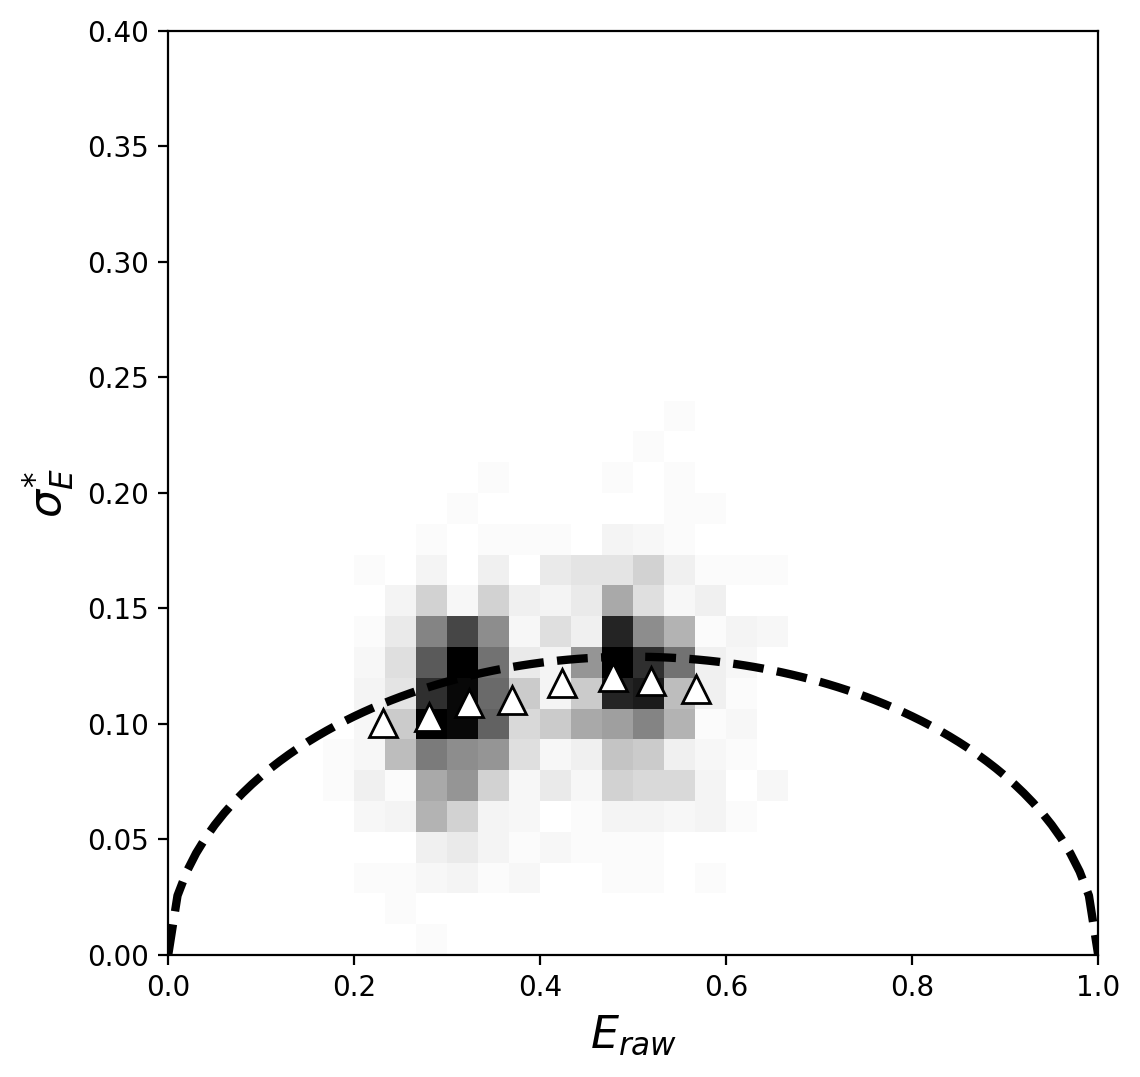

In [23]:
# Plot BVA
R = 20
n = 15
B_Thr = 20

E_da, std_da = BVA(ds_sel, n)
E_da_bin, std_da_bin = bin_bva(E_da, std_da, R, B_Thr)
E_da, std_da = np.concatenate(E_da), np.concatenate(std_da)
plt.figure(figsize=(6,6))
x_T=np.arange(0,1.01,0.01)
y_T=np.sqrt((x_T*(1-x_T))/n)
plt.plot(x_T,y_T, lw=3, color='k', ls='--')
plt.plot (E_da_bin , std_da_bin, marker="^", color='white', mew=1, mec='k', lw=0, ms=10, alpha=1)
plt.xlim(-0.01,1.01)
plt.ylim(0,0.4)
plt.hist2d(E_da, std_da, cmap = 'Greys', bins = (30, 30), range = ((0, 1), (0, 0.4)))
plt.xlabel(r'$E_{raw}$', fontsize=16)
plt.ylabel('$\sigma_{E}^{*}$', fontsize=16)
#plt.title(r'Simulation: $\tau_{A \leftrightarrow B} = 100 \ \mu s$')
plt.show()

In [24]:
mp_sel = bhm.BurstData(ds_sel)

mp_sel.models.calc_models(max_iter = 3600, to_state=5)

The model converged after 3 iterations

The model converged after 80 iterations

Optimization reached maximum number of iterations

Optimization reached maximum number of iterations

Optimization reached maximum number of iterations

1

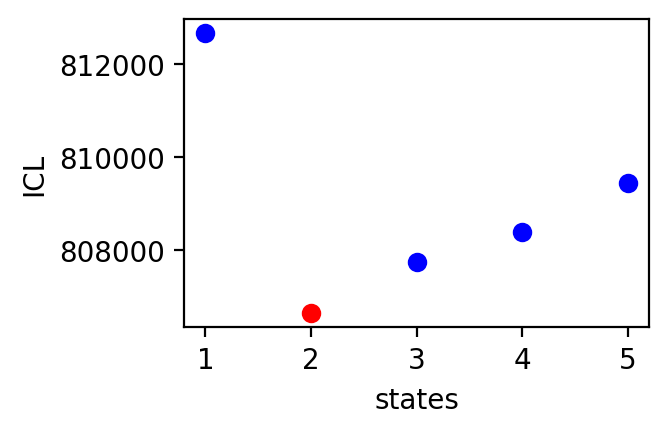

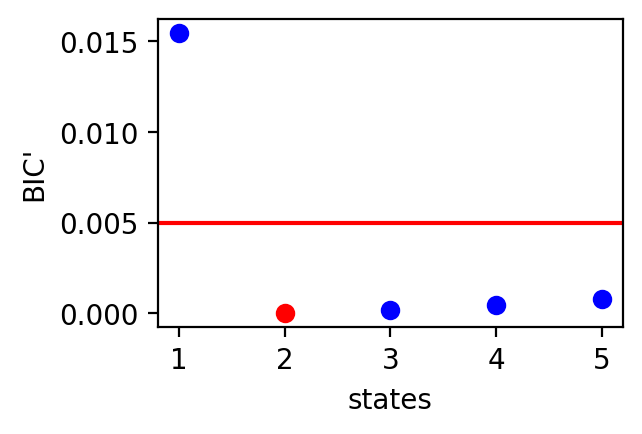

In [25]:
plt.figure(figsize=(3, 2))
mp_sel.models.find_ideal('ICL', auto_set=True)
bhm.ICL_plot(mp_sel.models, highlight_ideal=True)
plt.show()

plt.figure(figsize=(3, 2))
mp_sel.models.find_ideal('BICp', auto_set=True)
bhm.BICp_plot(mp_sel.models, highlight_ideal=True)
plt.axhline(0.005, c = "r")
plt.show()

In [26]:
mp_sel.models[1]

/opt/miniconda3/envs/pybromo/lib/python3.9/site-packages/burstH2MM/BurstSort.py:1836: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  style_frame[f'to_state_{t}'][f'state_{f}'] = 'background-color: lightcoral'
/opt/miniconda3/envs/pybromo/lib/

,E_raw,S_raw,to_state_0,to_state_1
state_0,0.499836,0.505759,19999993.898065,6.101935
state_1,0.308107,0.502831,11.850104,19999988.149896


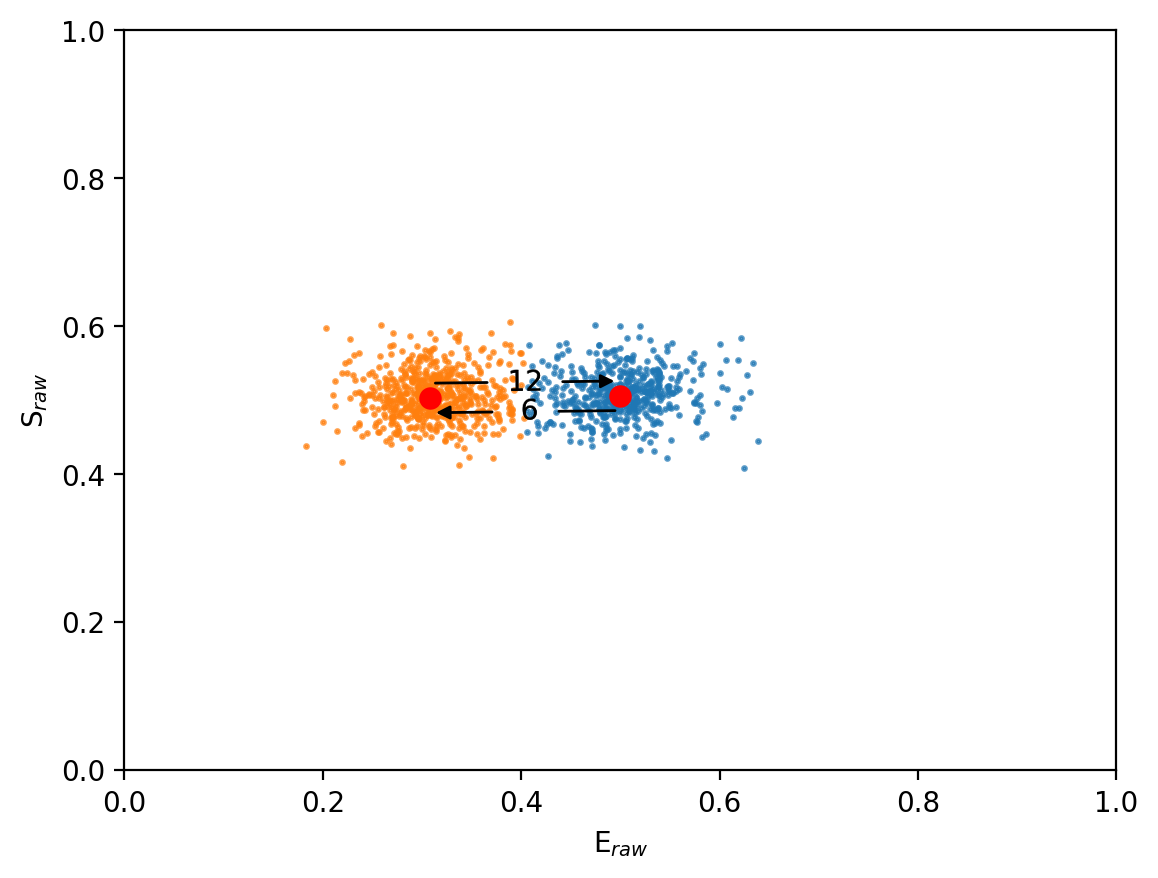

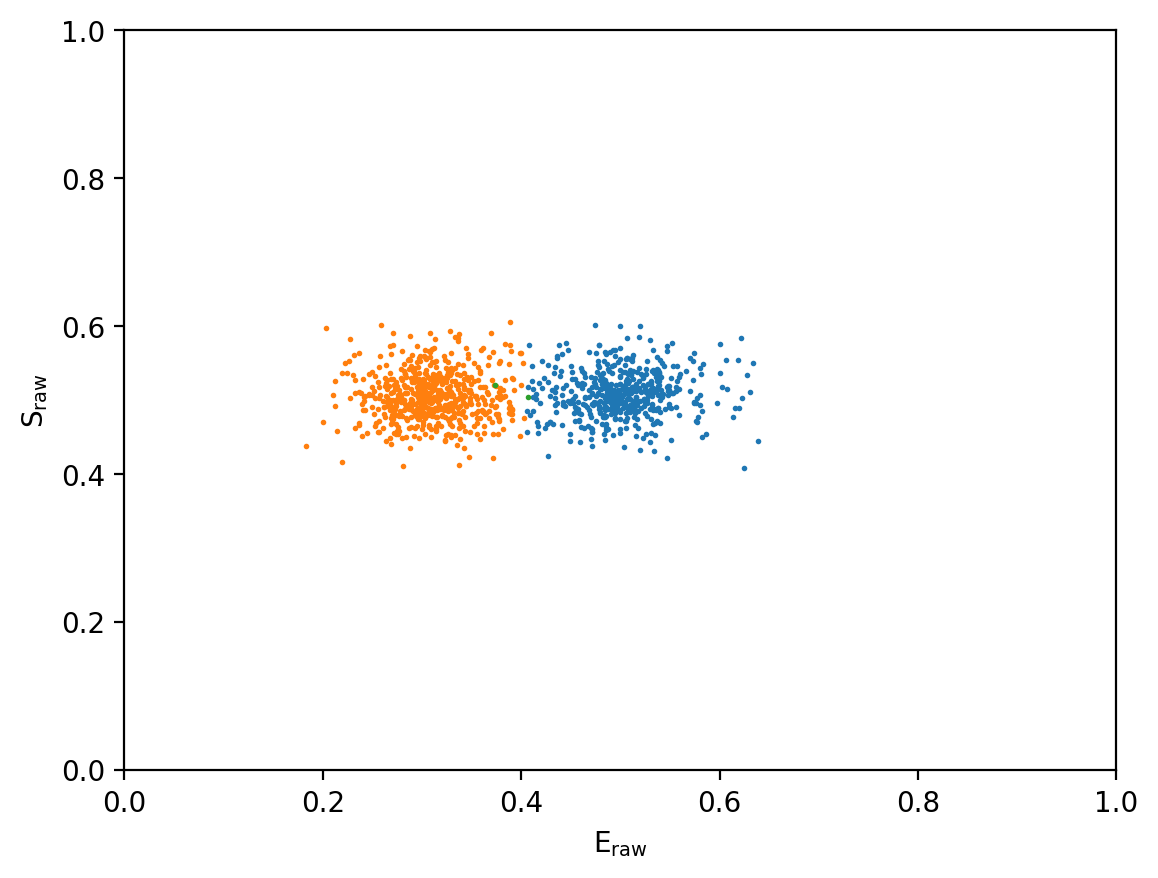

In [27]:
model_id = 1

bhm.dwell_ES_scatter(mp_sel.models[model_id], s = 2)
bhm.trans_arrow_ES(mp_sel.models[model_id], min_rate=0)
#bhm.axline_E(mp.models[model_id])
bhm.scatter_ES(mp_sel.models[model_id], s = 50, color = "r")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

bhm.burst_ES_scatter(mp_sel.models[model_id], flatten_dynamics=True, s = 1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## Comparison of the blinking, with the cleaned, and without blinking

In [28]:
d_nonblink = fb.loader.photon_hdf5(
        "smFRET_aa3ff9_E30E50_2states_taus_1000.0ms1000.0ms0.0ms.h5"
)
d_nonblink.add(D_ON=(100, 2100), A_ON=(2150, 4095))
fb.loader.alex_apply_period(d_nonblink)

d_nonblink.calc_bg(fun=fb.bg.exp_fit, time_s = 60, F_bg=1.7)
d_nonblink.burst_search(F=7, m = 10)
d_nonblink.fuse_bursts(ms = 0)

d_nonblinks = d_nonblink.select_bursts(fb.select_bursts.size, add_naa = False, th1=60)
d_nonblinks = d_nonblinks.select_bursts(fb.select_bursts.naa, th1=40)


        The current file lacks the alternation period definition.
        You will need to manually add this info using:

          d.add(D_ON=D_ON, A_ON=A_ON)

        where `d` is a Data object and D_ON/A_ON is a tuple with start/stop
        values defining the D/A excitation excitation period. Values are in
        raw timestamps units.
        


# Total photons (after ALEX selection):     4,406,919
#  D  photons in D+A excitation periods:    1,902,965
#  A  photons in D+A excitation periods:    2,503,954
# D+A photons in  D  excitation period:     2,221,871
# D+A photons in  A  excitation period:     2,185,048

 - Calculating BG rates ... get bg th arrays
Channel 0
[DONE]
 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]
 - - - - - CHANNEL  1 - - - - 
 --> END Fused 5902 bursts (33.8%, 14 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A and FRET]


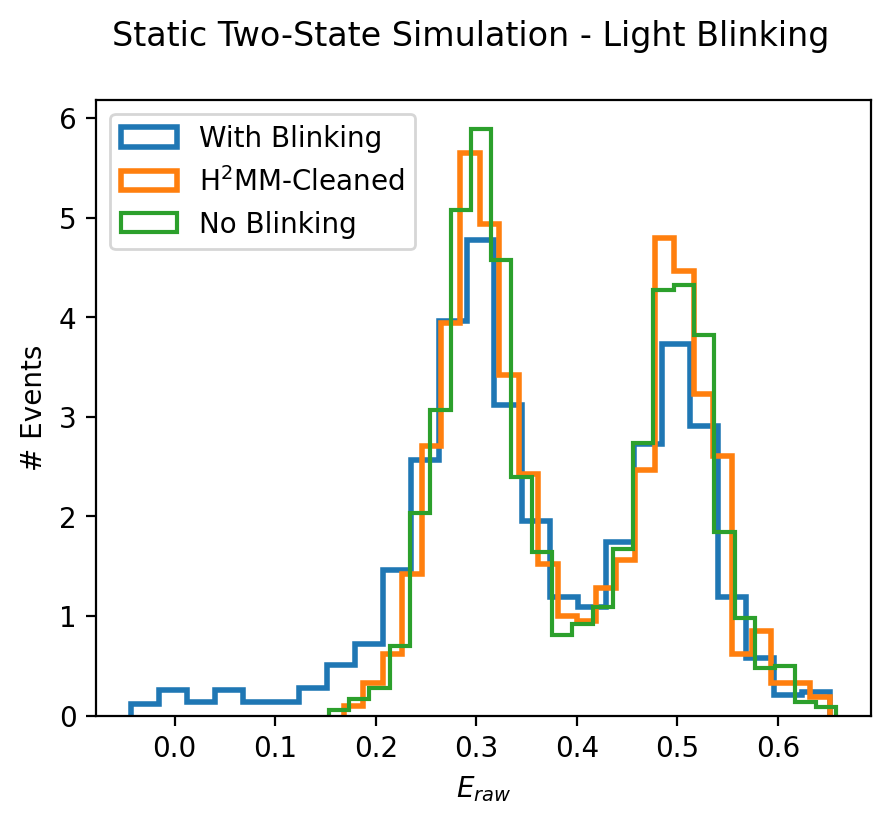

In [29]:
plt.figure(figsize=(5, 4))
plt.hist(ds.E[0], bins = 25, histtype = u"step", lw = 2, density = True, label = "With Blinking")
plt.hist(ds_sel.E[0], bins = 25, histtype = u"step", lw = 2,density = True, label = r"H$^2$MM-Cleaned")
plt.hist(d_nonblinks.E[0], bins = 25, histtype = u"step", lw = 1.5,density = True, label = "No Blinking")
plt.suptitle("Static Two-State Simulation - Light Blinking")
plt.legend(loc = 'best')
plt.xlabel(r'$E_{raw}$')
plt.ylabel('# Events')
plt.show()

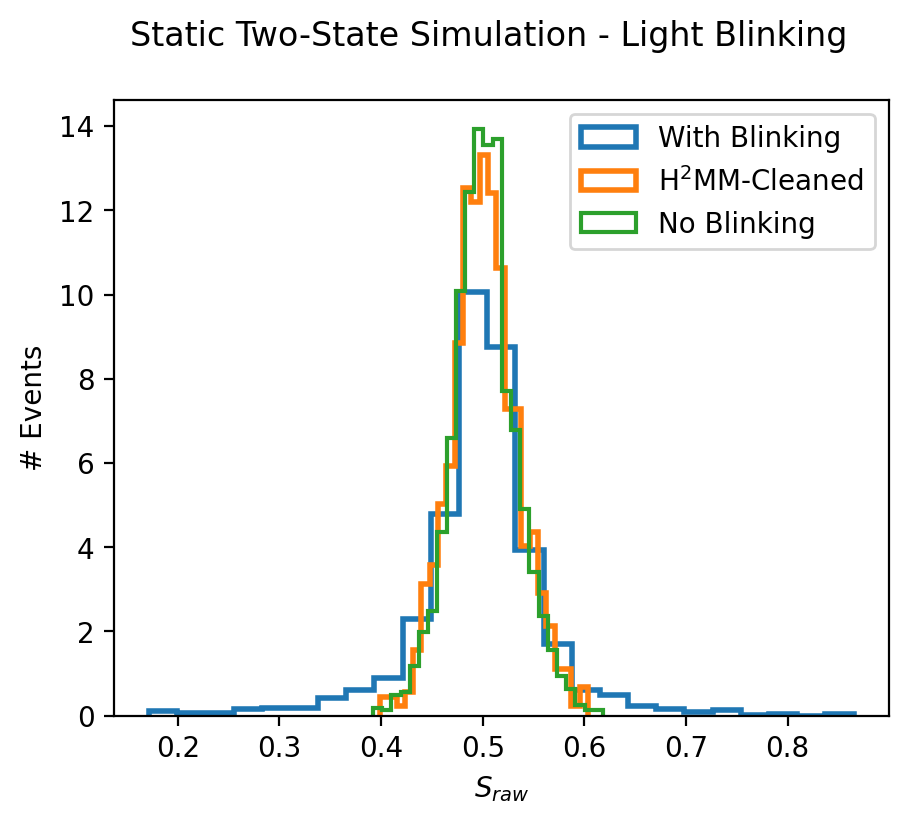

In [30]:
plt.figure(figsize=(5, 4))
plt.hist(ds.S[0], bins = 25, histtype = u"step", lw = 2, density = True, label = "With Blinking")
plt.hist(ds_sel.S[0], bins = 25, histtype = u"step", lw = 2,density = True, label = r"H$^2$MM-Cleaned")
plt.hist(d_nonblinks.S[0], bins = 25, histtype = u"step", lw = 1.5,density = True, label = "No Blinking")
plt.suptitle("Static Two-State Simulation - Light Blinking")
plt.legend(loc = 'best')
plt.xlabel(r'$S_{raw}$')
plt.ylabel('# Events')
plt.show()

## Comparison with ALEX-2CDE filtered data

In [31]:
# Alex 2CDE, from https://github.com/OpenSMFS/FRETBursts/blob/master/notebooks/Example%20-%202CDE%20Method.ipynb

def alex_2cde_filtering(fb_obj, tau_s = 50E-6, contrast = 150, alex_2cde_threshold = 95, plot = False):
    tau = int(tau_s/ds.clk_p)  # in raw timestamp units
    
    ph = fb_obj.ph_times_m[0]
    
    
    bursts = fb_obj.mburst[0]
    
    ph_dex = fb_obj.get_ph_times(ph_sel=fb.Ph_sel(Dex='DAem'))
    ph_aex = fb_obj.get_ph_times(ph_sel=fb.Ph_sel(Aex='Aem'))
    
    mask_dex = fb_obj.get_ph_mask(ph_sel=fb.Ph_sel(Dex='DAem'))
    mask_aex = fb_obj.get_ph_mask(ph_sel=fb.Ph_sel(Aex='Aem'))
    
    KDE_DexTi = fb.phtools.phrates.kde_laplace(ph_dex, tau, time_axis=ph)
    KDE_AexTi = fb.phtools.phrates.kde_laplace(ph_aex, tau, time_axis=ph)
    
    ALEX_2CDE = []
    BRDex, BRAex = [], []
    for ib, burst in enumerate(bursts):
        burst_slice = slice(int(burst.istart), int(burst.istop) + 1)
        if ~mask_dex[burst_slice].any() or ~mask_aex[burst_slice].any():
            # Either D or A photon stream has no photons in current burst,
            # thus ALEX_2CDE cannot be computed.
            ALEX_2CDE.append(np.nan)
            continue
    
        kde_dexdex = KDE_DexTi[burst_slice][mask_dex[burst_slice]]
        kde_aexdex = KDE_AexTi[burst_slice][mask_dex[burst_slice]]
        N_chaex = mask_aex[burst_slice].sum()
        BRDex.append(np.sum(kde_aexdex / kde_dexdex) / N_chaex)
    
        kde_aexaex = KDE_AexTi[burst_slice][mask_aex[burst_slice]]
        kde_dexaex = KDE_DexTi[burst_slice][mask_aex[burst_slice]]
        N_chdex = mask_dex[burst_slice].sum()
        BRAex.append(np.sum(kde_dexaex / kde_aexaex) / N_chdex)
    
        alex_2cde = 100 - contrast*(BRDex[-1] - BRAex[-1])
        ALEX_2CDE.append(alex_2cde)
    ALEX_2CDE = np.array(ALEX_2CDE)

    if plot:
        plt.hist2d(fb_obj.E[0], ALEX_2CDE, bins = 50, range = ((-0.2, 1.2), (0, 150)))
        plt.xlabel("E")
        plt.ylabel("ALEX-2CDE")
        plt.title(f"ALEX-2CDE with tau = {tau_s*1E6} µs")
        plt.show()
        plt.hist2d(fb_obj.S[0], ALEX_2CDE, bins = 50, vmax = 50, range = ((-0.2, 1.2), (0, 150)))
        plt.xlabel("S")
        plt.ylabel("ALEX-2CDE")
        plt.title(f"ALEX-2CDE with tau = {tau_s*1E6} µs")
        plt.show()
    
    
    # Create mask based on ALEX-2CDE, E, and S
    valid = np.isfinite(ALEX_2CDE)
    masks = [valid * (ALEX_2CDE > alex_2cde_threshold)]
    fb_data_alex = fb_obj.select_bursts_mask_apply(masks)

    return fb_data_alex


In [32]:
ds_alex = alex_2cde_filtering(ds)

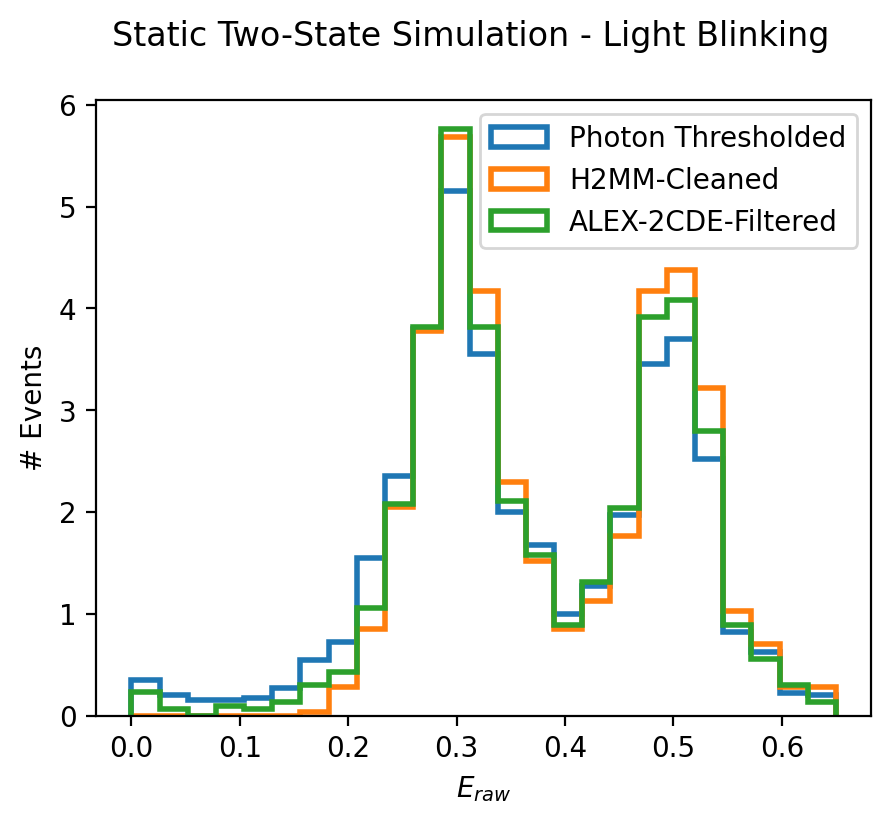

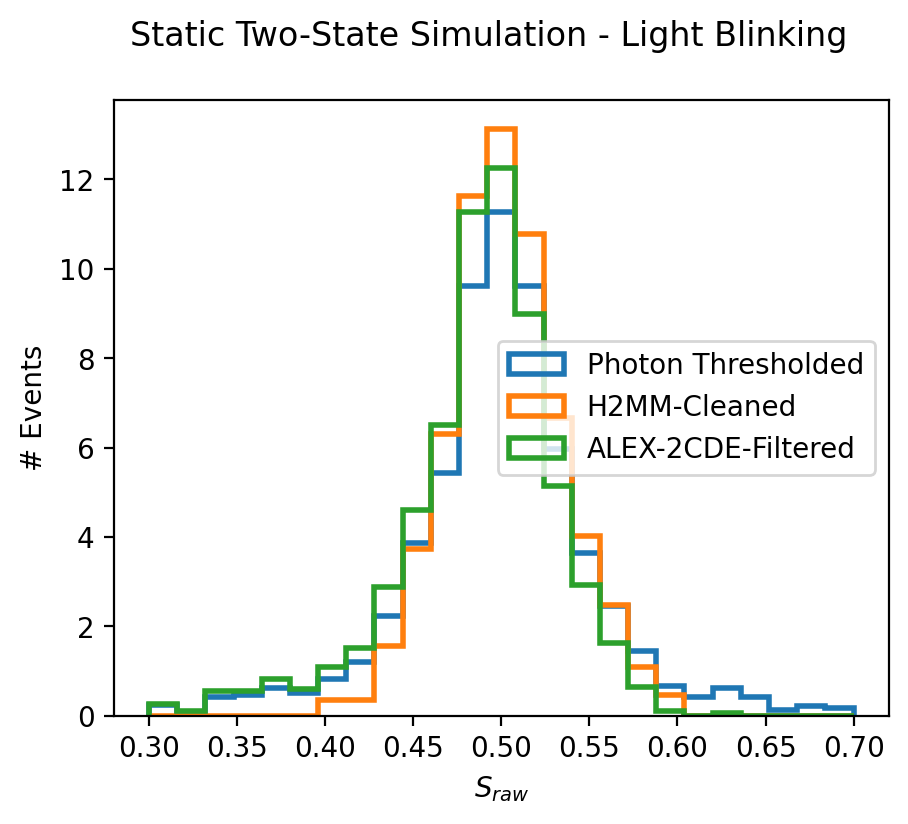

In [35]:
plt.figure(figsize=(5, 4))
plt.hist(ds.E[0], bins = 25, range=(0, 0.65), histtype=u"step", lw = 2, density = True, label = "Photon Thresholded")
plt.hist(ds_sel.E[0], bins = 25, range=(0, 0.65), histtype=u"step", lw = 2, density = True, label = "H2MM-Cleaned")
plt.hist(ds_alex.E[0], bins = 25, range=(0, 0.65), histtype=u"step", lw = 2, density = True, label = "ALEX-2CDE-Filtered")
plt.legend(loc = "best")
plt.suptitle("Static Two-State Simulation - Light Blinking")
plt.legend(loc = 'best')
plt.xlabel(r'$E_{raw}$')
plt.ylabel('# Events')
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(ds.S[0], bins = 25, range=(0.3, 0.7), histtype=u"step", lw = 2, density = True, label = "Photon Thresholded")
plt.hist(ds_sel.S[0], bins = 25, range=(0.3, 0.7), histtype=u"step", lw = 2, density = True, label = "H2MM-Cleaned")
plt.hist(ds_alex.S[0], bins = 25, range=(0.3, 0.7), histtype=u"step", lw = 2, density = True, label = "ALEX-2CDE-Filtered")
plt.legend(loc = "best")
plt.suptitle("Static Two-State Simulation - Light Blinking")
plt.legend(loc = 'best')
plt.xlabel(r'$S_{raw}$')
plt.ylabel('# Events')
plt.show()

## H2MM Fit of ALEX-2CDE filtered data

In [107]:
mp_alex = bhm.BurstData(ds_alex)

In [108]:
mp_alex.models.calc_models(to_state=5, max_iter=3200)

The model converged after 1 iterations

The model converged after 50 iterations

The model converged after 56 iterations

The model converged after 166 iterations

The model converged after 383 iterations

3

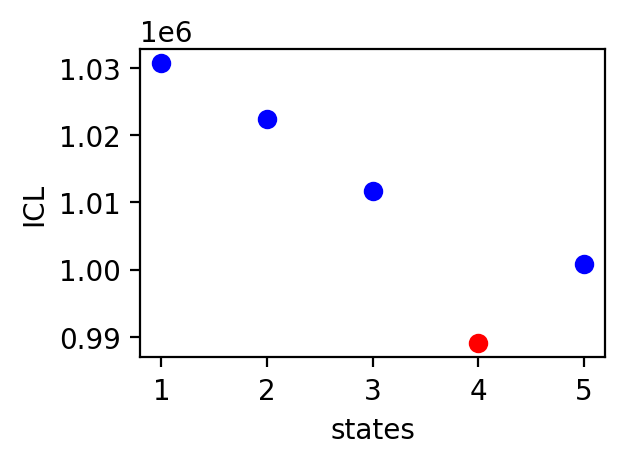

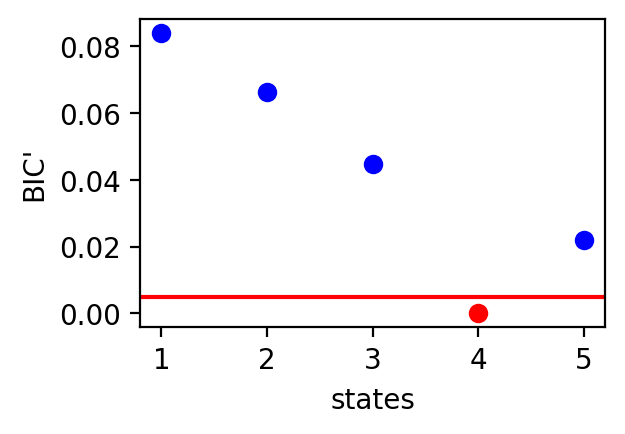

In [112]:
plt.figure(figsize=(3, 2))
mp_alex.models.find_ideal('ICL', auto_set=True)
bhm.ICL_plot(mp_alex.models, highlight_ideal=True)
plt.show()

plt.figure(figsize=(3, 2))
mp_alex.models.find_ideal('BICp', auto_set=True)
bhm.BICp_plot(mp_alex.models, highlight_ideal=True)
plt.axhline(0.005, c = "r")
plt.show()

In [113]:
model_id = 3

mp_alex.models[model_id]

/opt/miniconda3/envs/pybromo/lib/python3.9/site-packages/burstH2MM/BurstSort.py:1836: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  style_frame[f'to_state_{t}'][f'state_{f}'] = 'background-color: lightcoral'
/opt/miniconda3/envs/pybromo/lib/

,E_raw,S_raw,to_state_0,to_state_1,to_state_2,to_state_3
state_0,0.012447,0.984362,19996559.309911,530.932623,2032.944455,876.813011
state_1,0.499415,0.502952,32.717599,19999891.467670,70.941896,4.872836
state_2,0.527042,0.024139,515.408932,500.855827,19998400.495662,583.239579
state_3,0.307450,0.501337,37.434817,8.349124,71.964137,19999882.251922


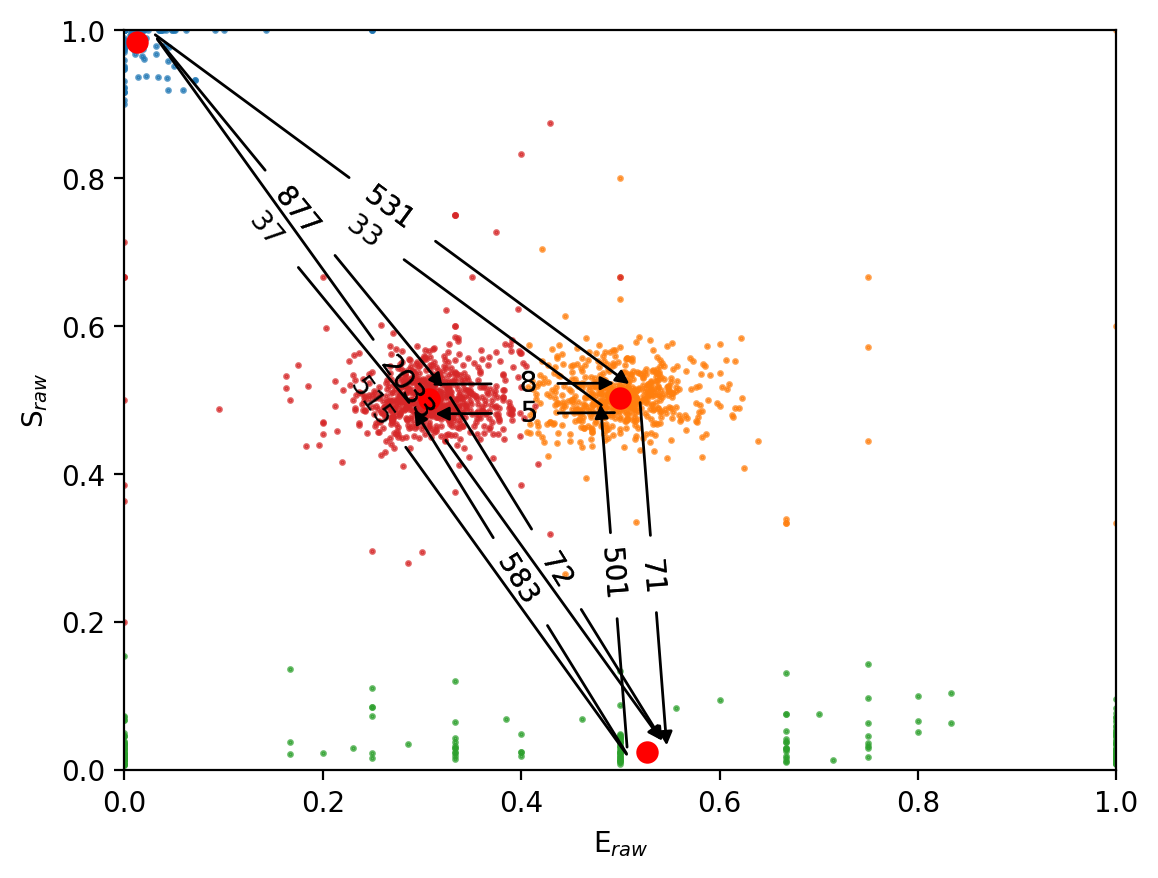

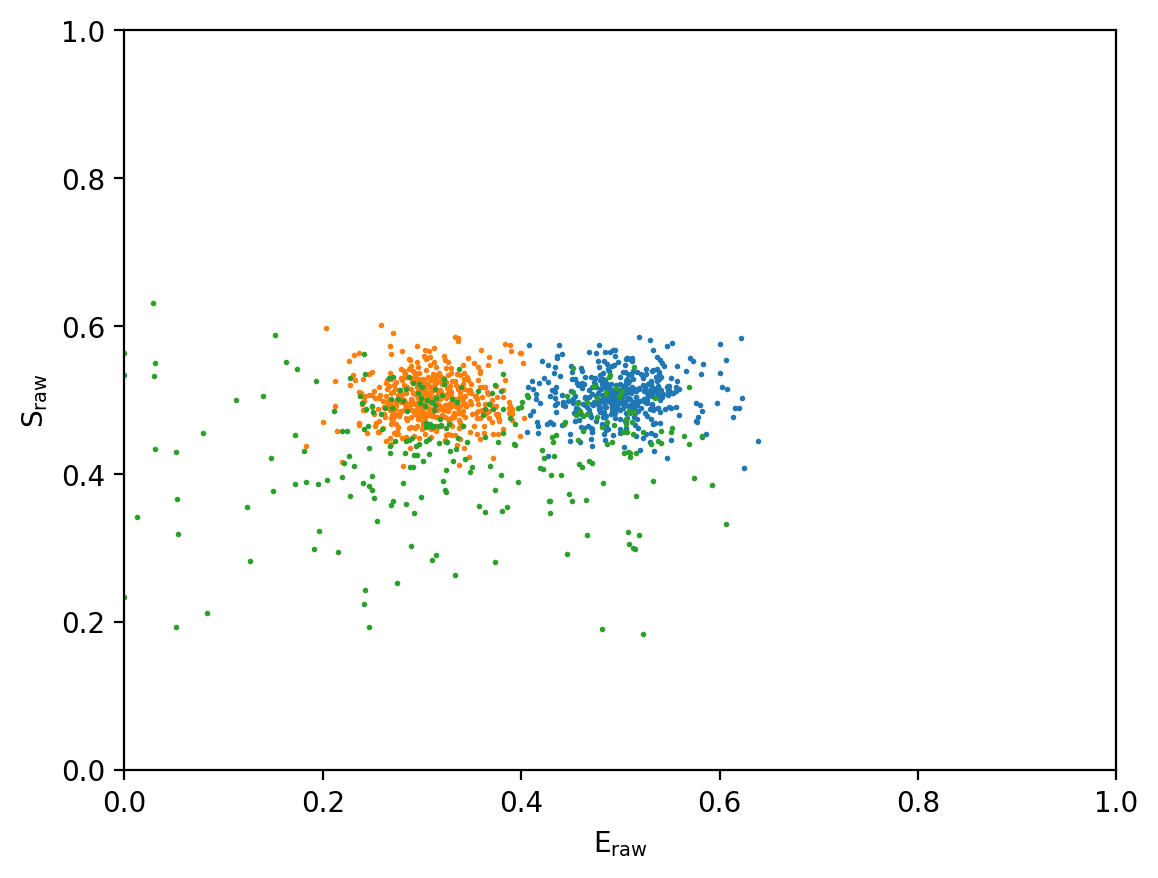

In [110]:
model_id = 3

bhm.dwell_ES_scatter(mp_alex.models[model_id], s = 2)
bhm.trans_arrow_ES(mp_alex.models[model_id], min_rate=1)
#bhm.axline_E(mp.models[model_id])
bhm.scatter_ES(mp_alex.models[model_id], s = 50, color = "r")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

bhm.burst_ES_scatter(mp_alex.models[model_id], flatten_dynamics=True, s = 1)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()